In [ ]:
%matplotlib inline

from IPython.display import HTML, Latex, Math, display, Image
import datetime
import ephem

# Data analysis
import numpy as np
import pandas as pd
import re
import csv

# Create spherical-map
import healpy as hp
import seaborn as sns

# Import skyfield
from skyfield.api import load, Topos
from skyfield.api import utc

# Manage & convert astro coordinates
import astropy.units as u
import astropy.coordinates as Coord
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.coordinates import get_sun, AltAz, EarthLocation
from astropy.time import Time

# Tools for Rayleigh analysis
from scipy.optimize import minimize, least_squares, curve_fit
from scipy.stats import chi2
from scipy.special import erfcinv

# Plotting
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

In [ ]:
sns.set()

def eq2gal(ra, dec):
    '''
    Transforms equatorial coordinates to galactic ones.
    Then prepares them for matplotlib aitoff projection. 
    '''
    eq = SkyCoord(ra, dec, unit=u.deg)
    gal = eq.galactic

    # Minus appears because of “mapping from the inside” issue
    l_gal, b_gal = -gal.l.wrap_at('180d').radian, gal.b.radian
    
    return l_gal, b_gal

def ecl2gal(lon_ecl, lat_ecl):
    '''
    Transforms ecliptic coordinates to galactic ones.
    Then prepares them for matplotlib aitoff projection.
    '''
    ecl = SkyCoord(lon_ecl, lat_ecl, unit=u.deg, frame='barycentricmeanecliptic')
    gal = ecl.transform_to('galactic')

    # Minus appears because of “mapping from the inside” issue
    l_gal, b_gal = -gal.l.wrap_at('180d').radian, gal.b.radian
    
    return l_gal, b_gal

def ecl2eq(lon_ecl, lat_ecl):
    '''
    Transforms ecliptic coordinates to equatorial ones.
    Then prepares them for matplotlib aitoff projection.
    '''
    ecl = SkyCoord(lon_ecl, lat_ecl, unit=u.deg, frame='barycentricmeanecliptic')
    eq = ecl.icrs

    # Convert RA to the range [0, 360) degrees
    ra_eq = eq.ra.wrap_at(360 * u.deg).radian
    dec_eq = eq.dec.radian
    
    return ra_eq, dec_eq

def gal2eq(l_gal, b_gal):
    """
    Transform Galactic coordinates to Equatorial coordinates.
    
    Parameters:
    - l_gal: Galactic longitude in degrees
    - b_gal: Galactic latitude in degrees
    
    Returns:
    - ra_eq: Right ascension in degrees
    - dec_eq: Declination in degrees
    """
    # Create a SkyCoord object for the input Galactic coordinates
    galactic_coords = SkyCoord(l=l_gal, b=b_gal, unit=u.deg, frame='galactic')
    
    # Transform to Equatorial coordinates (ICRS frame)
    equatorial_coords = galactic_coords.icrs
    
    # Extract RA and Dec in degrees
    ra_eq = equatorial_coords.ra.deg
    dec_eq = equatorial_coords.dec.deg
    
    # Minus appears because of “mapping from the inside” issue
    ra_eq, dec_eq = -equatorial_coords.ra.wrap_at('180d').radian, -equatorial_coords.dec.radian
    
    return ra_eq, dec_eq

In [ ]:
# Tanganyika
Tanganyika_lon = 29.833332  
Tanganyika_lat = -6.500000
gal_Tanganyika_l, gal_Tanganyika_b = eq2gal(Tanganyika_lat, Tanganyika_lon)

print(np.radians(Tanganyika_lat))

# Pylos
Pylos_lon = 21.696346	
Pylos_lat = 36.913074
gal_Pylos_l, gal_Pylos_b = eq2gal(Pylos_lat,Pylos_lon)

In [ ]:
# Some points are interesting to explore, first the closest galaxy Centaurus A
# following: https://www.mdpi.com/2218-1997/8/11/607
RA_centaurus = 195.424
D_centaurus = -43.0191666667
gal_centaurus_l, gal_centaurus_b = eq2gal(RA_centaurus, D_centaurus)

RA_3C273 = 187.2791666667
D_3C273 = 2.0525
gal_3C273_l, gal_3C273_b = gal2eq(RA_3C273, D_3C273)

RA_FornaxA = 50.67995833
D_FornaxA = -37.199524
gal_FornaxA_l, gal_FornaxA_b = eq2gal(RA_FornaxA, D_FornaxA)

RA_CygnusA = 299.8681525
D_CygnusA = 40.7339155556
gal_CygnusA_l, gal_CygnusA_b = eq2gal(RA_CygnusA, D_CygnusA)

RA_HerculasA = 252.7839583333 
D_HerculasA = 4.9925888889
gal_HerculasA_l, gal_HerculasA_b = eq2gal(RA_HerculasA, D_HerculasA)

RA_M83 = 204.2538291667
D_M83 = -29.8657611111 
gal_M83_l, gal_M83_b = eq2gal(RA_M83, D_M83)

RA_M87 = 187.7042
D_M87 = 12.3911
gal_M87_l, gal_M87_b = eq2gal(RA_M87, D_M87)

RA_NGC1218 = 47.10975
D_NGC1218 = 4.1113888889
gal_NGC1218_l, gal_NGC1218_d = eq2gal(RA_NGC1218, D_NGC1218)

RA_NGC1275 = 49.9515416667 
D_NGC1275 = 41.5114472222
gal_NGC1275_l, gal_NGC1275_d = eq2gal(RA_NGC1275, D_NGC1275)

RA_Centre = 266.4168333333 
D_Centre = -29.0078055556
gal_Centre_l, gal_Centre_d = eq2gal(RA_Centre, D_Centre)

In [ ]:
# The below data is of events detected by IceCube
# https://arxiv.org/pdf/1311.5238.pdf
# https://link.springer.com/article/10.1140/epjc/s10052-015-3519-1
# https://arxiv.org/abs/1304.5356

E_IceCube = [47.6, 117, 78.7, 165, 71.4, 28.4, 34.3, 32.6, 63.2, 97.2, 88.4, 104, 253, 1041, 57.5, 30.6, 200, 31.5, 71.5, 1141, 30.2, 220, 82.2, 30.5, 33.5, 210, 60.1, 46.1]
Decl_IceCube =[-1.8, -28.0, -31.2, -51.2, -0.4, -27.2, -45.1, -21.2, 33.6, -29.4, -8.9,-52.8, 40.3, -27.9, -49.7, -22.6, 14.5, -24.8, -59.7, -67.2, -24.0, -22.1, -13.2, -15.1, -14.5, 22.7, -12.6, -71.5]
RA_IceCube = [35.2, 282.6, 127.9, 169.5, 110.6, 133.9, 15.6, 182.4, 151.3, 5.0, 155.3, 296.1, 67.9, 265.6, 287.3, 192.1, 247.4, 345.6, 76.9, 38.3, 9.0, 293.7, 208.7, 282.2, 286.0, 143.4, 121.7, 164.8]

gal_IceCube_l, gal_IceCube_b = eq2gal(RA_IceCube, Decl_IceCube)

In [ ]:
# Sources from IceCube source
# https://arxiv.org/pdf/1910.08488.pdf


name_sources = ["PKS 2320-035", "3C 454.3", "TXS 2241+406", "RGB J2243+203", "CTA 102", "BL Lac", "OX 169", "B2 2114+33",
         "PKS 2032+107", "2HWC J2031+415", "Gamma Cygni", "MGRO J2019+37", "MG2 J201534+3710", "MG4 J200112+4352",
         "1ES 1959+650", "1RXS J194246.3+1", "RX J1931.1+0937", "NVSS J190836-012", "MGRO J1908+06", "TXS 1902+556",
         "HESS J1857+026", "GRS 1285.0", "HESS J1852-000", "HESS J1849-000", "HESS J1843-033", "OT 081", "S4 1749+70",
         "1H 1720+117", "PKS 1717+177", "Mkn 501", "4C +38.41", "PG 1553+113", "GB6 J1542+6129", "B2 1520+31",
         "PKS 1502+036", "PKS 1502+106", "PKS 1441+25", "PKS 1424+240", "NVSS J141826-023", "B3 1343+451", "S4 1250+53",
         "PG 1246+586", "MG1 J123931+0443", "M 87", "ON 246", "3C 273", "4C +21.35", "W Comae", "PG 1218+304",
         "PKS 1216-010", "B2 1215+30", "Ton 599", "PKS B1130+008", "Mkn 421", "4C +01.28", "1H 1013+498", "4C +55.17", 
         "M 82", "PMN J0948+0022", "OJ 287", "PKS 0829+046", "S4 0814+42", "OJ 014", "1ES 0806+524", "PKS 0736+01", "PKS 0735+17", 
         "4C +14.23", "S5 0716+71", "PSR B0656+14", "1ES 0647+250", "B3 0609+413", "Crab nebula", "OG +050", "TXS 0518+211",
         "TXS 0506+056", "PKS 0502+049", "S3 0458-02", "PKS 0440-00", "MG2 J043337+2905", "PKS 0422+00", "PKS 0420-01",
         "PKS 0336-01", "NGC 1275", "NGC 1068", "PKS 0235+164", "4C +28.07", "3C 66A", "B2 0218+357", "PKS 0215+015",
         "MG1 J021114+1051", "TXS 0141+268", "B3 0133+388", "NGC 598", "S2 0109+22", "4C +01.02", "M 31", "PKS 0019+058",
         "PKS 2233-148", "HESS J1841-055", "HESS J1837-069", "PKS 1510-089", "PKS 1329-049", "NGC 4945", "3C 279",
         "PKS 0805-07", "PKS 0727-11", "LMC", "SMC", "PKS 0048-09", "NGC 253"]


# Declination (δ)
DEC_sources = [-3.29, 16.15, 40.96, 20.36, 11.73, 42.28, 17.73, 33.66, 10.94, 41.51, 40.26, 36.80, 37.19, 43.89, 65.15,
               10.56, 9.63, -1.53, 6.18, 55.68, 2.67, 0.69, 0.00, -0.02, -3.30, 9.65, 70.10, 11.88, 17.75, 39.76, 38.14,
               11.19, 61.50, 31.74, 3.44, 10.50, 25.03, 23.80, -2.56, 44.88, 53.02, 58.34, 4.73, 12.39, 25.30, 2.04,
               21.38, 28.24, 30.17, -1.33, 30.12, 29.24, 0.58, 38.21, 1.56, 49.43, 55.38, 69.67, 0.37, 20.12, 4.49, 42.38, 
               1.78, 52.31, 1.62, 17.71, 14.42, 71.34, 14.24, 25.06, 41.37, 22.01, 7.55, 21.21, 5.70, 5.00, -1.97, -0.29, 
               29.10, 0.60, -1.33, -1.77, 41.51, -0.01, 16.62, 28.80, 43.04, 35.94, 1.74, 10.58, 27.09, 39.10, 30.62, 22.75,
               1.59, 41.24, 6.14, -14.56, -5.55, -6.93, -9.10, -5.16, -49.47, -5.79, -7.86, -11.69, -68.75, -72.75, -9.49, -25.29]

# Right Ascension (α)
RA_sources = [350.88, 343.50, 341.06, 340.99, 338.15, 330.69, 325.89, 319.06, 308.85, 307.93, 305.56, 304.85, 303.92,
              300.30, 300.01, 295.70, 292.78, 287.20, 287.17, 285.80, 284.30, 283.15, 283.00, 282.26, 280.75, 267.87,
              267.15, 261.27, 259.81, 253.47, 248.82, 238.93, 235.75, 230.55, 226.26, 226.10, 220.99, 216.76, 214.61,
              206.40, 193.31, 192.08, 189.89, 187.71, 187.56, 187.27, 186.23, 185.38, 185.34, 184.64, 184.48, 179.88, 
              173.20, 166.12, 164.61, 153.77, 149.42, 148.95, 147.24, 133.71, 127.97, 124.56, 122.87, 122.46, 114.82,
              114.54, 111.33, 110.49, 104.95, 102.70, 93.22, 83.63, 83.18, 80.44, 77.35, 76.34, 75.30, 70.66, 68.41,
              66.19, 65.83, 54.88, 49.96, 40.67, 39.67, 39.48, 35.67, 35.28, 34.46, 32.81, 26.15, 24.14, 23.52, 18.03, 
              17.16, 10.82, 5.64, 339.14, 280.23, 279.43, 228.21, 203.02, 196.36, 194.04, 122.07, 112.58, 80.00, 14.50, 
              12.68, 11.90]

# in Mpc
name_sources = [10202, 2208, 8082, 3331.5, 2453, 276, "OX 169", "B2 2114+33",
         "PKS 2032+107", "2HWC J2031+415", "Gamma Cygni", "MGRO J2019+37", "MG2 J201534+3710", "MG4 J200112+4352",
         "1ES 1959+650", "1RXS J194246.3+1", "RX J1931.1+0937", "NVSS J190836-012", "MGRO J1908+06", "TXS 1902+556",
         "HESS J1857+026", "GRS 1285.0", "HESS J1852-000", "HESS J1849-000", "HESS J1843-033", "OT 081", "S4 1749+70",
         "1H 1720+117", "PKS 1717+177", "Mkn 501", "4C +38.41", "PG 1553+113", "GB6 J1542+6129", "B2 1520+31",
         "PKS 1502+036", "PKS 1502+106", "PKS 1441+25", "PKS 1424+240", "NVSS J141826-023", "B3 1343+451", "S4 1250+53",
         "PG 1246+586", "MG1 J123931+0443", "M 87", "ON 246", "3C 273", "4C +21.35", "W Comae", "PG 1218+304",
         "PKS 1216-010", "B2 1215+30", "Ton 599", "PKS B1130+008", "Mkn 421", "4C +01.28", "1H 1013+498", "4C +55.17", 
         "M 82", "PMN J0948+0022", "OJ 287", "PKS 0829+046", "S4 0814+42", "OJ 014", "1ES 0806+524", "PKS 0736+01", "PKS 0735+17", 
         "4C +14.23", "S5 0716+71", "PSR B0656+14", "1ES 0647+250", "B3 0609+413", "Crab nebula", "OG +050", "TXS 0518+211",
         "TXS 0506+056", "PKS 0502+049", "S3 0458-02", "PKS 0440-00", "MG2 J043337+2905", "PKS 0422+00", "PKS 0420-01",
         "PKS 0336-01", "NGC 1275", "NGC 1068", "PKS 0235+164", "4C +28.07", "3C 66A", "B2 0218+357", "PKS 0215+015",
         "MG1 J021114+1051", "TXS 0141+268", "B3 0133+388", "NGC 598", "S2 0109+22", "4C +01.02", "M 31", "PKS 0019+058",
         "PKS 2233-148", "HESS J1841-055", "HESS J1837-069", "PKS 1510-089", "PKS 1329-049", "NGC 4945", "3C 279",
         "PKS 0805-07", "PKS 0727-11", "LMC", "SMC", "PKS 0048-09", "NGC 253"]
gal_sources_l, gal_sources_d = eq2gal(RA_sources, DEC_sources)

In [ ]:
# TDE Events
# https://tde.space/
# Define the column names based on the byte-by-byte description
columns = ["Name", "Disc. Date", "mmax", "Host Name", "Host R.A.", "Host Dec.", "z", "Type", "Phot.", "Spec.", "X-ray"]

# Load the data into a pandas DataFrame using ',' as the separator and handling quotes
df = pd.read_excel("The Open TDE Catalog.xlsx", skiprows=1, header=None, names=columns)

# Create a new DataFrame with non-NaN values in both "Host R.A." and "Host Dec."
filtered_df = df.dropna(subset=["Host R.A.", "Host Dec.", "z"])

# Create lists for non-NaN values in "Host R.A." and "Host Dec."
host_ra_list = filtered_df["Host R.A."].tolist()
host_dec_list = filtered_df["Host Dec."].tolist()
z_list = filtered_df["z"].tolist()
z_array = np.array(z_list, dtype=float)

# Define a function to convert RA from string to degrees
def ra_to_deg(ra_str):
    ra = Angle(ra_str, unit="hourangle")
    return ra.deg

# Define a function to convert Dec from string to degrees
def dec_to_deg(dec_str):
    dec = Angle(dec_str, unit="deg")
    return dec.deg
    
# Convert RA/Dec values to degrees and remove single quotes
host_ra_deg_list = [ra_to_deg(ra) for ra in host_ra_list]
host_dec_deg_list = [dec_to_deg(dec) for dec in host_dec_list]

# Convert TDE redshift to distance
TDE_velocity = [i * (3 * 10**5) for i in z_array]
TDE_distance = [i / 70 for i in TDE_velocity]

# Copnvert into galactic coordinates
l_TDE_gal, b_TDE_gal = eq2gal(host_ra_deg_list, host_dec_deg_list)

print(min(TDE_distance))

In [ ]:
# Equatorial plane
ra_all = np.linspace(-180, 180, 100)
dec_0 = np.zeros(100)
l_eq_gal, b_eq_gal = eq2gal(ra_all, dec_0)

# Ecliptic plane
lon_ecl = np.linspace(0, 360, 100)
lat_ecl = np.zeros(100)
l_ecl_gal, b_ecl_gal = ecl2gal(lon_ecl, lat_ecl)


# plot the figure
plt.figure(figsize=(14,7))
plt.subplot(111, projection='aitoff')

plt.scatter(l_eq_gal, b_eq_gal, s=4, marker='v', label='Celestial Equator', color='black')
plt.scatter(l_ecl_gal, b_ecl_gal, s=4, marker='^', label='Ecliptic', color='maroon')

# Essential thing is to rename RA axis ticks to transform them to conventional format
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

plt.xlabel('l = Longitude [degrees]')
plt.ylabel('b = Latitude [degrees]')

plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.title('Galactic', fontsize='16')

plt.show()

In [ ]:
# Determine the hemisphere (North or South) based on celestial latitude
is_northern_hemisphere = ra_all >= 0

# Equatorial plane
ra_all = np.linspace(-180, 180, 100)
dec_0 = np.zeros(100)
l_eq_cel, b_eq_cel = ra_all, dec_0

# Ecliptic plane
lon_ecl = np.linspace(-180, 180, 100)
lat_ecl = np.zeros(100)
l_ecl_cel, b_ecl_cel = ecl2eq(lon_ecl, lat_ecl)

# Galactic plane
l_gal_plane = np.linspace(-180, 180, 100)
b_gal_plane = np.zeros(100) 
l_gal_cel, b_gal_cel = gal2eq(l_gal_plane, b_gal_plane)

# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Fill the area above the celestial equator with a different color
ax.fill_between(np.radians(l_gal_cel), np.pi, where=is_northern_hemisphere, alpha=0.01)

# Fill the area below the celestial equator with a different color
ax.fill_between(np.radians(l_eq_gal), -np.pi, where=~is_northern_hemisphere, color='yellow', alpha=0.1)

ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='maroon')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='maroon')
ax.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])


ax.set_xlabel('Right Ascension [degrees]')
ax.set_ylabel('Declination [degrees]')
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.title('Celestial', fontsize='16')

plt.show()

The following link is the source for the blazar data: https://www.ssdc.asi.it/bzcat/#filter.

In [ ]:
# AGN
# Define the column names based on the byte-by-byte description
columns = ["TMID", "RAdeg", "DEdeg", "Vel", "CAT", "Type", "S/N-1", "S/N-2", "KMag", "SSPChi2",
           "Ha-FWHMB", "Ha-FluxB", "e_Ha-FluxB", "Hb-Flux", "Ha-Flux", "O3-Flux", "N2-Flux",
           "S2a-Flux", "S2b-Flux", "e_Hb-Flux", "e_Ha-Flux", "e_O3-Flux", "e_N2-Flux",
           "e_S2a-Flux", "e_S2b-Flux", "Hb-FWHMB"]

# Load the data into a pandas DataFrame
df = pd.read_fwf("AGN.txt", skiprows=52, header=None, names=columns)

# Display the DataFrame
#print(df)
#print(df['RAdeg'])

# BLAZAR
columns_blazar = ["id", "5BZCAT Name", "Source Classification", "R.A. (J2000)", "Dec. (J2000)", "Redshift", 
                  "Redshift Flag", "1.4 GHz (0.843 MHz) Flux Density (mJy)", "143 GHz Flux Density (mJy)", 
                  "Optical Magnitude (mag)", "0.1-2.4 keV Flux (10-12 erg cm-2 s-1)", "1-100 GeV Flux (ph cm-2 s-1)"]

# Load the data into a pandas DataFrame
df_blazar = pd.read_csv("Blazar.txt", delimiter=r"\s*\|\s*", engine='python', skipinitialspace=True, skiprows=1, header=None, names=columns_blazar, delim_whitespace=False)

# Display the DataFrame
#print(df_blazar.head())
print(df_blazar["R.A. (J2000)"])

In [ ]:
# Take out the coordinates from the data frame for the AGNs
ra_points = df['RAdeg']
dec_points = df['DEdeg']
vel_points = df['Vel']
dis_points = [abs(i) / 70 for i in vel_points]            # use Hubble's law to get the distance in Mpc from the redshift 
red_points = [i / (3 * 10**5) for i in vel_points]        # calculate the redshift for the sources

# Take out the blazar values
ra_blazar = df_blazar['R.A. (J2000)']
dec_blazar = df_blazar['Dec. (J2000)']

# Take out the redshift for the blazars and convert it to velocity and eventually distance
redshift = df_blazar['Redshift']
velocity = [i * (3 * 10**5) for i in redshift]
distance = [i / 70 for i in velocity]

# Transform the coordinates to a different frame
ra, dec = eq2gal(ra_blazar, dec_blazar)

# The Blazar distances contain NaN values, remove these and adapt the other lists containing the RA and DEC values as well
valid_indices = ~np.isnan(distance)

# Convert lists to NumPy arrays for easier manipulation
distance = np.array(distance)
ra = np.array(ra)
dec = np.array(dec)

# Filter out NaN values and corresponding values in other arrays
distance = distance[valid_indices]
ra = ra[valid_indices]
dec = dec[valid_indices]
ra_blazar = ra_blazar[valid_indices]
dec_blazar = dec_blazar[valid_indices]

# We want the scaling factor to scale with the flux which scales with 1/r^2
# We want to scale the dot size of each of the AGNs with the distance they are away from us
s_scaling_factor = 30000000.0
s = [s_scaling_factor / (max(dis_points) * i**(2)) for i in dis_points]

# We want to scale the dot size of each of the blazars with the distance they are away from us
b_scaling_factor = 30000000.0
b = [b_scaling_factor / (max(dis_points) * i**(2)) for i in distance]

# We want to scale the dot size of each of the TDE's with the distance they are away from us
TDE_scaling_factor = 30000000.0
TDE = [TDE_scaling_factor / (max(dis_points) * i**(2)) for i in TDE_distance]

# We want to scale the dot size of each of the neutrinos from IceCube with their energy
n_scaling_factor = 1000.0
n = [(i * n_scaling_factor) / (max(E_IceCube)) for i in E_IceCube]

# We want to scale the dot size of each of the neutrinos from IceCube with their energy
t_scaling_factor = 100.0
t = [t_scaling_factor / ((max(z_array)) * (i)**2) for i in z_array]

# Transform the data to galactic coordinates
l_points, b_points = eq2gal(ra_points, dec_points)

# Distances of all the galaxies in Mpc
dis_M87 = 16.4
dis_CentaurusA = 4.00
dis_FornaxA = 19
dis_CygnusA = 233
dis_HerculasA = 6439
dis_M83 = 4.61
dis_NGC1218 = 116.08
dis_NGC1275 = 70.5
# Make them into scaling factors
s_M87 = (s_scaling_factor / (max(dis_points) * dis_M87**2))
s_CentaurusA = (s_scaling_factor / (max(dis_points) * dis_CentaurusA**2))
s_FornaxA = (s_scaling_factor / (max(dis_points) * dis_FornaxA**2))
s_CygnusA = (s_scaling_factor / (max(dis_points) * dis_CygnusA**2))
s_HerculasA = (s_scaling_factor / (max(dis_points) * dis_HerculasA**2))
s_M83 = (s_scaling_factor / (max(dis_points) * dis_M83**2)) 
s_NGC1218 = (s_scaling_factor / (max(dis_points) * dis_NGC1218**2)) 
s_NGC1275 = (s_scaling_factor / (max(dis_points) * dis_NGC1275**2))



# plot the figure
plt.figure(figsize=(14, 7))
ax = plt.subplot(111, projection='aitoff')

y1 = plt.scatter(l_points, b_points, s=s, label='AGN', color='blue', alpha=0.1)
y2 = plt.scatter(ra, dec, label='blazar', s=b, color='orange', alpha=0.5)

z1 = plt.scatter(l_eq_gal, b_eq_gal, s=6, marker='v', label='Celestial Equator', color='black')
z2 = plt.scatter(l_ecl_gal, b_ecl_gal, s=6, marker='^', label='Ecliptic', color='maroon')
#plt.scatter(lapland, litouwen, s=1000, color='green', label='closest')

# Other Galaxies
galaxies_handles = [
    plt.scatter(gal_centaurus_l, gal_centaurus_b, s=200, marker='x', color='yellowgreen'),
    plt.scatter(gal_FornaxA_l, gal_FornaxA_b, s=200, marker='8', color='yellowgreen'),
    plt.scatter(gal_CygnusA_l, gal_CygnusA_b, s=200, marker='p', color='yellowgreen'),
    plt.scatter(gal_HerculasA_l, gal_HerculasA_b, s=200, marker='X', color='yellowgreen'),
    plt.scatter(gal_M87_l, gal_M87_b, s=200, marker='s', color='yellowgreen'),
    plt.scatter(gal_M83_l, gal_M83_b, s=200, marker='d', color='yellowgreen'),
    plt.scatter(gal_NGC1218_l, gal_NGC1218_d, s=200, marker='*', color='yellowgreen'),
    plt.scatter(gal_NGC1275_l, gal_NGC1275_d, s=200, marker='+', color='yellowgreen')]

plt.scatter(gal_centaurus_l, gal_centaurus_b, s=s_CentaurusA, alpha=0.3, color='yellowgreen')
plt.scatter(gal_FornaxA_l, gal_FornaxA_b, s=s_FornaxA, alpha=0.3, color='yellowgreen')
plt.scatter(gal_CygnusA_l, gal_CygnusA_b, s=s_CygnusA, alpha=0.3, color='yellowgreen')
plt.scatter(gal_HerculasA_l, gal_HerculasA_b, s=s_HerculasA, alpha=0.3, color='yellowgreen')
plt.scatter(gal_M87_l, gal_M87_b, s=s_M87, alpha=0.3, color='yellowgreen')
plt.scatter(gal_M83_l, gal_M83_b, s=s_M83, alpha=0.3, color='yellowgreen')
plt.scatter(gal_NGC1218_l, gal_NGC1218_d, s=s_NGC1218, alpha=0.3, color='yellowgreen')
plt.scatter(gal_NGC1275_l, gal_NGC1275_d, s=s_NGC1275, alpha=0.3, color='yellowgreen')

galaxies_labels = ['Centaurus A', 'Fornax A', 'Cygnus A', 'Herculas A', 'M87', 'M83', 'NGC 1218', 'NGC 1275']

# IceCube events
y3 = plt.scatter(gal_IceCube_l, gal_IceCube_b, s=n, label='IceCube Events', color='darkturquoise')

# TDE Events (can be scaled to distance by putting s=t)
y4 = plt.scatter(l_TDE_gal, b_TDE_gal, s=TDE, label='TDE Events', alpha=0.2, color='yellow')       #teal

# Events from the IceCube paper with possible sources
y5 = plt.scatter(gal_sources_l, gal_sources_d, s=30, label='Possible Sources', alpha=0.7, color='teal')

# Essential thing is to rename RA axis ticks to transform them to conventional format
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

plt.xlabel('l = Longitude [degrees]')
ax.set_ylabel('b = Latitude [degrees]')

plt.grid(True)

# Create the first legend
legend1 = ax.legend(handles=galaxies_handles, labels=galaxies_labels, loc='lower right', fontsize='9', bbox_to_anchor=(1.01, -0.065), scatterpoints=1, markerscale=0.7)
# Add the first legend to the axis
ax.add_artist(legend1)

# Create the second legend
legend2 = ax.legend(handles=[y2, y3, y5], loc='lower right', fontsize='9', bbox_to_anchor=(0.895, -0.065), scatterpoints=1, markerscale=0.5)
# Add the second legend to the axis
ax.add_artist(legend2)

# Create the third legend
legend3 = ax.legend(handles=[z1, z2], loc='lower left', fontsize='9', bbox_to_anchor=(-0.05, -0.062))
# Add the second legend to the axis
ax.add_artist(legend3)

# Create the sixth legend
legend6 = ax.legend(handles=[y1, y4], loc='lower right', fontsize='8', bbox_to_anchor=(0.753, -0.062), scatterpoints=1, markerscale=0.08)
# Add the first legend to the axis
ax.add_artist(legend6)


plt.title('Galactic', fontsize='16')
plt.savefig("Galactic Sources.jpg")
plt.show()

In [ ]:
def draw_circle(center_lat, center_lon, radius_degrees, num_points=1000):
    """
    Draw a circle on the celestial map.

    Parameters:
    - center_lat: Latitude of the center point (in radians).
    - center_lon: Longitude of the center point (in radians).
    - radius_degrees: Radius of the circle (in degrees).
    - num_points: Number of points to generate on the circle.

    Returns:
    - circle_lat: Array of latitude coordinates forming the circle.
    - circle_lon: Array of longitude coordinates forming the circle.
    """
    # Convert radius to radians
    radius_radians = np.radians(radius_degrees)

    # Generate angles for the circle points
    angles = np.linspace(0, 2 * np.pi, num_points)

    # Calculate coordinates of points on the circle
    circle_lat = np.arcsin(np.sin(center_lat) * np.cos(radius_radians) +
                           np.cos(center_lat) * np.sin(radius_radians) * np.cos(angles))
    circle_lon = center_lon + np.arctan2(np.sin(angles) * np.sin(radius_radians) * np.cos(center_lat),
                                         np.cos(radius_radians) - np.sin(center_lat) * np.sin(circle_lat))

    return circle_lat, circle_lon

# Example usage for Tanganyika coordinates with a 90-degree radius
Tanganyika_lat_rad = np.radians(Tanganyika_lat)
Tanganyika_lon_rad = np.radians(Tanganyika_lon)
Pylos_lat_rad = np.radians(Pylos_lat)
Pylos_lon_rad = np.radians(Pylos_lon)
radius_degrees = 90.0

circle_lat, circle_lon = draw_circle(Tanganyika_lat_rad, Tanganyika_lon_rad, radius_degrees)
circle_Pylos_lat, circle_Pylos_lon = draw_circle(Pylos_lat_rad, Pylos_lon_rad, radius_degrees)

The following sky map shows the AGNs from the catalogue in: https://iopscience.iop.org/article/10.3847/1538-4357/aaffaf.

In [ ]:
# Sagitarius A
A_ra = 4.0025000
A_dec = 

# Take out the coordinates from the data frame
ra_points = -(df['RAdeg'] - 180)
dec_points = np.radians(df['DEdeg'])

# Transform RA to the range [0, 360)
ra_points = np.radians(ra_points)

# Equatorial plane
ra_all = np.linspace(-180, 180, 100)
dec_0 = np.zeros(100)
l_eq_cel, b_eq_cel = np.radians(ra_all), np.radians(dec_0)

# Ecliptic plane
lon_ecl = np.linspace(-180, 180, 100)
lat_ecl = np.zeros(100)
l_ecl_cel, b_ecl_cel = ecl2eq(lon_ecl, lat_ecl)

# Galactic plane
l_gal_plane = np.linspace(-180, 180, 100)
b_gal_plane = np.zeros(100)
l_gal_cel, b_gal_cel = gal2eq(l_gal_plane, b_gal_plane)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': 'aitoff'})

# Fill the area above the celestial equator with a different color
ax.fill_between(np.radians(l_gal_cel), np.pi, where=is_northern_hemisphere, alpha=0.01)

# Fill the area below the celestial equator with a different color
ax.fill_between(np.radians(l_eq_gal), -np.pi, where=~is_northern_hemisphere, color='yellow', alpha=0.1)

# plot the figure
y1 = plt.scatter(ra_points, dec_points, label='AGN', s=s, color='blue', alpha=0.1)
y2 = plt.scatter(-np.radians(ra_blazar-180), np.radians(dec_blazar), label='blazar', s=b, color='orange', alpha=0.5)

# Put in the two possible Locations of the detector and plot the 90 degree circle
a1 = plt.scatter(np.radians(Tanganyika_lon), np.radians(Tanganyika_lat), s=200, marker='s', label='Tanganyika', color='black')
a2 = plt.scatter(np.radians(Pylos_lon), np.radians(Pylos_lat), s=200, marker='p', label='Pylos', color='black')
a3 = plt.plot(circle_lon, circle_lat, linestyle='dashed', color='black', label='90 degree Tanganyika', alpha=0.3, linewidth=2)
a4 = plt.plot(circle_Pylos_lon, circle_Pylos_lat, linestyle='dashdot', color='black', label='90 degree Pylos', alpha=0.3, linewidth=2)

z1 = ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='maroon')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='maroon')
z2 = ax.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Other Galaxies
x1 = plt.scatter(-np.radians(RA_M87-180), np.radians(D_M87), s=200, marker='s', label='M87', color='yellowgreen')
x2 = plt.scatter(-np.radians(RA_centaurus-180), np.radians(D_centaurus), s=200, marker='x', label='Centaurus A', color='yellowgreen')
x3 = plt.scatter(-np.radians(RA_FornaxA-180), np.radians(D_FornaxA), s=200, marker='8', label='Fornax A', color='yellowgreen')
x4 = plt.scatter(-np.radians(RA_CygnusA-180), np.radians(D_CygnusA), s=200, marker='p', label='Cygnus A', color='yellowgreen')
x5 = plt.scatter(-np.radians(RA_HerculasA-180), np.radians(D_HerculasA), s=200, marker='X', label='Herculas A', color='yellowgreen')
x6 = plt.scatter(-np.radians(RA_M83-180), np.radians(D_M83), s=200, marker='d', label='M83', color='yellowgreen')
x7 = plt.scatter(-np.radians(RA_NGC1218-180), np.radians(D_NGC1218), s=200, marker='*', label='NGC 1218', color='yellowgreen')
x8 = plt.scatter(-np.radians(RA_NGC1275-180), np.radians(D_NGC1275), s=200, marker='+', label='NGC 1275', color='yellowgreen')

plt.scatter(-np.radians(RA_M87-180), np.radians(D_M87), s=s_M87, alpha=0.3, label='M87', color='yellowgreen')
plt.scatter(-np.radians(RA_centaurus-180), np.radians(D_centaurus), s=s_CentaurusA, alpha=0.3, label='Centaurus A', color='yellowgreen')
plt.scatter(-np.radians(RA_FornaxA-180), np.radians(D_FornaxA), s=s_FornaxA, alpha=0.3, label='Fornax A', color='yellowgreen')
plt.scatter(-np.radians(RA_CygnusA-180), np.radians(D_CygnusA), s=s_CygnusA, alpha=0.3, label='Cygnus A', color='yellowgreen')
plt.scatter(-np.radians(RA_HerculasA-180), np.radians(D_HerculasA), s=s_HerculasA, alpha=0.3, label='Herculas A', color='yellowgreen')
plt.scatter(-np.radians(RA_M83-180), np.radians(D_M83), s=s_M83, label='M83', alpha=0.3, color='yellowgreen')
plt.scatter(-np.radians(RA_NGC1218-180), np.radians(D_NGC1218), s=s_NGC1218, alpha=0.3, label='NGC 1218', color='yellowgreen')
plt.scatter(-np.radians(RA_NGC1275-180), np.radians(D_NGC1275), s=s_NGC1275, alpha=0.3, label='NGC 1275', color='yellowgreen')

# IceCube events
RA_IceCube180 = [i - 180 for i in RA_IceCube]
y3 = plt.scatter(-np.radians(RA_IceCube180), np.radians(Decl_IceCube), s=n, label='IceCube Events', color='darkturquoise')

# TDE Events
host_ra_deg_list180 = [i - 180 for i in host_ra_deg_list]
y4 = plt.scatter(-np.radians(host_ra_deg_list180), np.radians(host_dec_deg_list), s=TDE, label='TDE Event', alpha=0.3, color='yellow')

# Events from the IceCube paper with possible sources
RA_sources180 = [i - 180 for i in RA_sources]
y5 = plt.scatter(-np.radians(RA_sources180), np.radians(DEC_sources), s=30, label='UHE Sources?', alpha=0.7, color='teal')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
              labels=['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'])

ax.set_xlabel('Right Ascension [degrees]')
ax.set_ylabel('Declination [degrees]')

# Create the first legend
legend1 = ax.legend(handles=[x1, x2, x3, x4, x5, x6, x7, x8], loc='lower right', fontsize='9', bbox_to_anchor=(1.01, -0.065), scatterpoints=1, markerscale=0.7)
# Add the first legend to the axis
ax.add_artist(legend1)

# Create the second legend
legend2 = ax.legend(handles=[y2, y3, y5], loc='upper right', fontsize='9', bbox_to_anchor=(0.908, 0.055), scatterpoints=1, markerscale=0.5)
# Add the second legend to the axis
ax.add_artist(legend2)

# Create the third legend
legend3 = ax.legend(handles=[z1, z2], loc='lower left', fontsize='9', bbox_to_anchor=(-0.05, 0.09))
# Add the third legend to the axis
ax.add_artist(legend3)

# Create the fourth legend
legend4 = ax.legend(handles=[a1, a2], loc='upper left', fontsize='9', bbox_to_anchor=(-0.05, 0.1), scatterpoints=1, markerscale=0.7)
# Add the fourth legend to the axis
ax.add_artist(legend4)

# Create the fifth legend for dashed and dashdot lines
legend5 = ax.legend(handles=[Line2D([0], [0], linestyle='dashed', color='black', label='90 degree Tanganyika', alpha=0.3, linewidth=2),
                             Line2D([0], [0], linestyle='dashdot', color='black', label='90 degree Pylos', alpha=0.3, linewidth=2)],
                   loc='upper left', fontsize='9', bbox_to_anchor=(-0.05, 0.02))

# Create the sixth legend
legend6 = ax.legend(handles=[y1, y4], loc='lower right', fontsize='9', bbox_to_anchor=(0.789, -0.064), scatterpoints=1, markerscale=0.08)
# Add the first legend to the axis
ax.add_artist(legend6)

# Add the fifth legend to the axis
ax.add_artist(legend5)

plt.grid(True)
plt.title('Celestial', fontsize='16')

# Adjust layout to accommodate legends
fig.tight_layout()

plt.savefig("Celestial Sources.jpg")
plt.show()

In [ ]:
# Define function that can update the location of earth.
def get_celestial_coordinates(observer_location, date):
    """
    Get celestial coordinates (right ascension and declination) of the Sun.

    Parameters:
    - observer_location: Dictionary with 'lat' (latitude) and 'lon' (longitude) keys.
    - date: Python datetime object representing the date and time for which to compute coordinates.

    Returns:
    - Tuple of (RA, Dec) in radians.
    """

    # Define observer location
    observer = EarthLocation(lat=observer_location['lat']*u.deg, lon=observer_location['lon']*u.deg)

    # Calculate Sun's coordinates
    sun = get_sun(Time(date))
    sun_altaz = sun.transform_to(AltAz(obstime=date, location=observer))
    
    # Return Sun's celestial coordinates
    return sun.ra.rad, sun.dec.rad

def update_positions(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    daily_rotation = np.radians(frame / 24 * 360)  # Assuming 24 hours in a day
    ra_points_updated = (ra + daily_rotation) % (2 * np.pi)
    ra_points_updated = np.where(ra_points_updated > np.pi, ra_points_updated - 2 * np.pi, ra_points_updated)
    return ra_points_updated, dec

# Function to update positions based on time and yearly rotation around the Sun
def update_positions_yearly(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    ra_points_updated, dec_points_updated = update_positions(frame, ra, dec)

    # Update positions based on yearly rotation around the Sun
    days_in_year = 365.25  # Average number of days in a year
    yearly_rotation = np.radians(frame / 24 * days_in_year * 360)

    # Calculate the Sun's position for the given frame
    sun_ra, sun_dec = get_celestial_coordinates({'lat': 0, 'lon': 0}, start_date + datetime.timedelta(hours=int(frame)))

    # Adjust right ascension and declination based on the Sun's position
    ra_points_updated = (ra_points_updated) % (2 * np.pi)
    ra_points_updated = np.where(ra_points_updated > np.pi, ra_points_updated - 2 * np.pi, ra_points_updated)

    # Reflect declination values that go beyond the range [-π/2, π/2]
    dec_points_updated = (dec_points_updated + sun_dec) 
    #dec_points_updated = (((dec_points_updated + sun_dec) % (np.pi)) - 0.5*np.pi)
    #dec_points_updated = np.where(dec_points_updated < 0, dec_points_updated + 0.5*np.pi, dec_points_updated - 0.5* np.pi)
    
    dec_points_updated = np.where(dec_points_updated > 0.5*np.pi, 0.5*np.pi - (dec_points_updated - 0.5*np.pi), dec_points_updated)
    dec_points_updated = np.where(dec_points_updated < 0.5*-np.pi, -0.5*np.pi - (dec_points_updated + 0.5*np.pi), dec_points_updated)

    ra_points_updated = np.where(dec_points_updated > 0.5*np.pi, ra_points_updated + np.pi, ra_points_updated)
    ra_points_updated = np.where(dec_points_updated < 0.5*-np.pi, ra_points_updated + np.pi, ra_points_updated)
    
    return ra_points_updated, dec_points_updated

# Function to update the plot
def update_plot(frame):
    ra_updated, dec_updated = update_positions(frame, ra_points, dec_points)
    bra_updated, bdec_updated = update_positions(frame, -np.radians(ra_blazar-180), np.radians(dec_blazar))
    tra_updated, tdec_updated = update_positions(frame, -np.radians(host_ra_deg_list180), np.radians(host_dec_deg_list))
    ra_updated1, dec_updated1 = update_positions(frame, -np.radians(RA_M87-180), np.radians(D_M87))
    ra_updated2, dec_updated2 = update_positions(frame, -np.radians(RA_centaurus-180), np.radians(D_centaurus))
    ra_updated3, dec_updated3 = update_positions(frame, -np.radians(RA_FornaxA-180), np.radians(D_FornaxA))
    ra_updated4, dec_updated4 = update_positions(frame, -np.radians(RA_CygnusA-180), np.radians(D_CygnusA))
    ra_updated5, dec_updated5 = update_positions(frame, -np.radians(RA_HerculasA-180), np.radians(D_HerculasA))
    ra_updated6, dec_updated6 = update_positions(frame, -np.radians(RA_M83-180), np.radians(D_M83))
    ra_updated7, dec_updated7 = update_positions(frame, -np.radians(RA_NGC1218-180), np.radians(D_NGC1218))
    ra_updated8, dec_updated8 = update_positions(frame, -np.radians(RA_NGC1275-180), np.radians(D_NGC1275))
    ra_updated9, dec_updated9 = update_positions(frame, -np.radians(RA_M87-180), np.radians(D_M87))
    ra_updated10, dec_updated10 = update_positions(frame, -np.radians(RA_centaurus-180), np.radians(D_centaurus))
    ra_updated11, dec_updated11 = update_positions(frame, -np.radians(RA_FornaxA-180), np.radians(D_FornaxA))
    ra_updated12, dec_updated12 = update_positions(frame, -np.radians(RA_CygnusA-180), np.radians(D_CygnusA))
    ra_updated13, dec_updated13 = update_positions(frame, -np.radians(RA_HerculasA-180), np.radians(D_HerculasA))
    ra_updated14, dec_updated14 = update_positions(frame, -np.radians(RA_M83-180), np.radians(D_M83))
    ra_updated15, dec_updated15 = update_positions(frame, -np.radians(RA_NGC1218-180), np.radians(D_NGC1218))
    ra_updated16, dec_updated16 = update_positions(frame, -np.radians(RA_NGC1275-180), np.radians(D_NGC1275))
    ra_updated17, dec_updated17 = update_positions(frame, l_gal_cel, b_gal_cel)
    
    sc.set_offsets(np.column_stack([ra_updated, dec_updated]))
    sc1.set_offsets(np.column_stack([bra_updated, bdec_updated]))
    sc2.set_offsets(np.column_stack([tra_updated, tdec_updated]))
    sc3.set_offsets(np.column_stack([ra_updated1, dec_updated1]))
    sc4.set_offsets(np.column_stack([ra_updated2, dec_updated2]))
    sc5.set_offsets(np.column_stack([ra_updated3, dec_updated3]))
    sc6.set_offsets(np.column_stack([ra_updated4, dec_updated4]))
    sc7.set_offsets(np.column_stack([ra_updated5, dec_updated5]))
    sc8.set_offsets(np.column_stack([ra_updated6, dec_updated6]))
    sc9.set_offsets(np.column_stack([ra_updated7, dec_updated7]))
    sc10.set_offsets(np.column_stack([ra_updated8, dec_updated8]))
    sc11.set_offsets(np.column_stack([ra_updated9, dec_updated9]))
    sc12.set_offsets(np.column_stack([ra_updated10, dec_updated10]))
    sc13.set_offsets(np.column_stack([ra_updated11, dec_updated11]))
    sc14.set_offsets(np.column_stack([ra_updated12, dec_updated12]))
    sc15.set_offsets(np.column_stack([ra_updated13, dec_updated13]))
    sc16.set_offsets(np.column_stack([ra_updated14, dec_updated14]))
    sc17.set_offsets(np.column_stack([ra_updated15, dec_updated15]))
    sc18.set_offsets(np.column_stack([ra_updated16, dec_updated16]))
    sc23.set_offsets(np.column_stack([ra_updated17, dec_updated17]))

    # Display time annotation
    time_text.set_text(f'Time: {start_date + datetime.timedelta(hours=int(frame))}')

    return sc, sc1, sc2, sc3, sc4,sc5, sc6, sc7, sc8, sc9, sc10, sc11,sc12, sc13, sc14, sc15, sc16, sc17, sc18, sc23,

# Function to update the plot and only move Tanganyika and Pylos
def update_plot_detectors(frame):
    ra_updated19, dec_updated19 = update_positions(frame, np.radians(Tanganyika_lon), np.radians(Tanganyika_lat))
    ra_updated20, dec_updated20 = update_positions(frame, np.radians(Pylos_lon), np.radians(Pylos_lat))
    ra_updated21, dec_updated21 = update_positions(frame, circle_lon_array, circle_lat_array)
    ra_updated22, dec_updated22 = update_positions(frame, circle_Pylos_lon, circle_Pylos_lat)

    sc19.set_offsets(np.column_stack([ra_updated19, dec_updated19]))
    sc20.set_offsets(np.column_stack([ra_updated20, dec_updated20]))
    sc21.set_offsets(np.column_stack([ra_updated21, dec_updated21]))
    sc22.set_offsets(np.column_stack([ra_updated22, dec_updated22]))
    
    # Display time annotation
    time_text.set_text(f'Time: {start_date + datetime.timedelta(hours=int(frame))}')

    return sc19, sc20, sc21, sc22, 
    
# Function to update the plot
def update_plot_yearly(frame):
    ra_updated, dec_updated = update_positions_yearly(frame, ra_points, dec_points)
    bra_updated, bdec_updated = update_positions_yearly(frame, -np.radians(ra_blazar-180), np.radians(dec_blazar))
    tra_updated, tdec_updated = update_positions_yearly(frame, -np.radians(host_ra_deg_list180), np.radians(host_dec_deg_list))
    ra_updated1, dec_updated1 = update_positions_yearly(frame, -np.radians(RA_M87-180), np.radians(D_M87))
    ra_updated2, dec_updated2 = update_positions_yearly(frame, -np.radians(RA_centaurus-180), np.radians(D_centaurus))
    ra_updated3, dec_updated3 = update_positions_yearly(frame, -np.radians(RA_FornaxA-180), np.radians(D_FornaxA))
    ra_updated4, dec_updated4 = update_positions_yearly(frame, -np.radians(RA_CygnusA-180), np.radians(D_CygnusA))
    ra_updated5, dec_updated5 = update_positions_yearly(frame, -np.radians(RA_HerculasA-180), np.radians(D_HerculasA))
    ra_updated6, dec_updated6 = update_positions_yearly(frame, -np.radians(RA_M83-180), np.radians(D_M83))
    ra_updated7, dec_updated7 = update_positions_yearly(frame, -np.radians(RA_NGC1218-180), np.radians(D_NGC1218))
    ra_updated8, dec_updated8 = update_positions_yearly(frame, -np.radians(RA_NGC1275-180), np.radians(D_NGC1275))
    ra_updated9, dec_updated9 = update_positions_yearly(frame, -np.radians(RA_M87-180), np.radians(D_M87))
    ra_updated10, dec_updated10 = update_positions_yearly(frame, -np.radians(RA_centaurus-180), np.radians(D_centaurus))
    ra_updated11, dec_updated11 = update_positions_yearly(frame, -np.radians(RA_FornaxA-180), np.radians(D_FornaxA))
    ra_updated12, dec_updated12 = update_positions_yearly(frame, -np.radians(RA_CygnusA-180), np.radians(D_CygnusA))
    ra_updated13, dec_updated13 = update_positions_yearly(frame, -np.radians(RA_HerculasA-180), np.radians(D_HerculasA))
    ra_updated14, dec_updated14 = update_positions_yearly(frame, -np.radians(RA_M83-180), np.radians(D_M83))
    ra_updated15, dec_updated15 = update_positions_yearly(frame, -np.radians(RA_NGC1218-180), np.radians(D_NGC1218))
    ra_updated16, dec_updated16 = update_positions_yearly(frame, -np.radians(RA_NGC1275-180), np.radians(D_NGC1275))
    
    sc.set_offsets(np.column_stack([ra_updated, dec_updated]))
    sc1.set_offsets(np.column_stack([bra_updated, bdec_updated]))
    sc2.set_offsets(np.column_stack([tra_updated, tdec_updated]))
    sc3.set_offsets(np.column_stack([ra_updated1, dec_updated1]))
    sc4.set_offsets(np.column_stack([ra_updated2, dec_updated2]))
    sc5.set_offsets(np.column_stack([ra_updated3, dec_updated3]))
    sc6.set_offsets(np.column_stack([ra_updated4, dec_updated4]))
    sc7.set_offsets(np.column_stack([ra_updated5, dec_updated5]))
    sc8.set_offsets(np.column_stack([ra_updated6, dec_updated6]))
    sc9.set_offsets(np.column_stack([ra_updated7, dec_updated7]))
    sc10.set_offsets(np.column_stack([ra_updated8, dec_updated8]))
    sc11.set_offsets(np.column_stack([ra_updated9, dec_updated9]))
    sc12.set_offsets(np.column_stack([ra_updated10, dec_updated10]))
    sc13.set_offsets(np.column_stack([ra_updated11, dec_updated11]))
    sc14.set_offsets(np.column_stack([ra_updated12, dec_updated12]))
    sc15.set_offsets(np.column_stack([ra_updated13, dec_updated13]))
    sc16.set_offsets(np.column_stack([ra_updated14, dec_updated14]))
    sc17.set_offsets(np.column_stack([ra_updated15, dec_updated15]))
    sc18.set_offsets(np.column_stack([ra_updated16, dec_updated16]))

    return sc, sc1, sc2, sc3, sc4,sc5, sc6, sc7, sc8, sc9, sc10, sc11, sc12, sc13, sc14, sc15, sc16, sc17, sc18,

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': 'aitoff'})

# Initial plot
sc = plt.scatter(ra_points, dec_points, label='AGN', s=s, color='blue', alpha=0.2)
sc1 = plt.scatter(-np.radians(ra_blazar-180), np.radians(dec_blazar), label='Blazar', s=b, color='orange', alpha=0.2)
sc2 = plt.scatter(-np.radians(host_ra_deg_list180), np.radians(host_dec_deg_list), s=TDE, label='TDE Event', alpha=0.3, color='yellow')
sc3 = plt.scatter(-np.radians(RA_M87-180), np.radians(D_M87), s=200, marker='s', label='M87', color='yellowgreen')
sc4 = plt.scatter(-np.radians(RA_centaurus-180), np.radians(D_centaurus), s=200, marker='x', label='Centaurus A', color='yellowgreen')
sc5 = plt.scatter(-np.radians(RA_FornaxA-180), np.radians(D_FornaxA), s=200, marker='8', label='Fornax A', color='yellowgreen')
sc6 = plt.scatter(-np.radians(RA_CygnusA-180), np.radians(D_CygnusA), s=200, marker='p', label='Cygnus A', color='yellowgreen')
sc7 = plt.scatter(-np.radians(RA_HerculasA-180), np.radians(D_HerculasA), s=200, marker='X', label='Herculas A', color='yellowgreen')
sc8 = plt.scatter(-np.radians(RA_M83-180), np.radians(D_M83), s=200, marker='d', label='M83', color='yellowgreen')
sc9 = plt.scatter(-np.radians(RA_NGC1218-180), np.radians(D_NGC1218), s=200, marker='*', label='NGC 1218', color='yellowgreen')
sc10 = plt.scatter(-np.radians(RA_NGC1275-180), np.radians(D_NGC1275), s=200, marker='+', label='NGC 1275', color='yellowgreen')
sc11 = plt.scatter(-np.radians(RA_M87-180), np.radians(D_M87), s=s_M87, alpha=0.3, label='M87', color='yellowgreen')
sc12 = plt.scatter(-np.radians(RA_centaurus-180), np.radians(D_centaurus), s=s_CentaurusA, alpha=0.3, label='Centaurus A', color='yellowgreen')
sc13 = plt.scatter(-np.radians(RA_FornaxA-180), np.radians(D_FornaxA), s=s_FornaxA, alpha=0.3, label='Fornax A', color='yellowgreen')
sc14 = plt.scatter(-np.radians(RA_CygnusA-180), np.radians(D_CygnusA), s=s_CygnusA, alpha=0.3, label='Cygnus A', color='yellowgreen')
sc15 = plt.scatter(-np.radians(RA_HerculasA-180), np.radians(D_HerculasA), s=s_HerculasA, alpha=0.3, label='Herculas A', color='yellowgreen')
sc16 = plt.scatter(-np.radians(RA_M83-180), np.radians(D_M83), s=s_M83, label='M83', alpha=0.3, color='yellowgreen')
sc17 = plt.scatter(-np.radians(RA_NGC1218-180), np.radians(D_NGC1218), s=s_NGC1218, alpha=0.3, label='NGC 1218', color='yellowgreen')
sc18 = plt.scatter(-np.radians(RA_NGC1275-180), np.radians(D_NGC1275), s=s_NGC1275, alpha=0.3, label='NGC 1275', color='yellowgreen')

# Put in the two possible Locations of the detector and plot the 90 degree circle
sc19 = plt.scatter(np.radians(Tanganyika_lon), np.radians(Tanganyika_lat), s=200, marker='s', label='Tanganyika', color='black')
sc20 = plt.scatter(np.radians(Pylos_lon), np.radians(Pylos_lat), s=200, marker='p', label='Pylos', color='black')
sc21 = plt.plot(circle_lon, circle_lat, linestyle='dashed', color='black', label='90 degree Tanganyika', alpha=0.3, linewidth=2)
sc22 = plt.plot(circle_Pylos_lon, circle_Pylos_lat, linestyle='dashdot', color='black', label='90 degree Pylos', alpha=0.3, linewidth=2)
sc23 = plt.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Celestial sphere grid (optional)
ax.grid(True)

# Set the start date for your simulation
start_date = datetime.datetime(2024, 1, 1)  # Adjust the date as needed

time_text = ax.text(-1.2, 1.6, '', color='black')

# Animate the plot
animation = FuncAnimation(fig, update_plot, frames=np.arange(0, 24, 1), interval=100)
animation.save('animation1.gif', writer='imagemagick', fps=10)

display(Image(filename='animation1.gif'))

plt.show()

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': 'aitoff'})

# Initial plot
sc = plt.scatter(ra_points, dec_points, label='AGN', s=s, color='blue', alpha=0.2)
sc1 = plt.scatter(-np.radians(ra_blazar-180), np.radians(dec_blazar), label='Blazar', s=b, color='orange', alpha=0.2)
sc2 = plt.scatter(-np.radians(host_ra_deg_list180), np.radians(host_dec_deg_list), s=TDE, label='TDE Event', alpha=0.3, color='yellow')
sc3 = plt.scatter(-np.radians(RA_M87-180), np.radians(D_M87), s=200, marker='s', label='M87', color='yellowgreen')
sc4 = plt.scatter(-np.radians(RA_centaurus-180), np.radians(D_centaurus), s=200, marker='x', label='Centaurus A', color='yellowgreen')
sc5 = plt.scatter(-np.radians(RA_FornaxA-180), np.radians(D_FornaxA), s=200, marker='8', label='Fornax A', color='yellowgreen')
sc6 = plt.scatter(-np.radians(RA_CygnusA-180), np.radians(D_CygnusA), s=200, marker='p', label='Cygnus A', color='yellowgreen')
sc7 = plt.scatter(-np.radians(RA_HerculasA-180), np.radians(D_HerculasA), s=200, marker='X', label='Herculas A', color='yellowgreen')
sc8 = plt.scatter(-np.radians(RA_M83-180), np.radians(D_M83), s=200, marker='d', label='M83', color='yellowgreen')
sc9 = plt.scatter(-np.radians(RA_NGC1218-180), np.radians(D_NGC1218), s=200, marker='*', label='NGC 1218', color='yellowgreen')
sc10 = plt.scatter(-np.radians(RA_NGC1275-180), np.radians(D_NGC1275), s=200, marker='+', label='NGC 1275', color='yellowgreen')
sc11 = plt.scatter(-np.radians(RA_M87-180), np.radians(D_M87), s=s_M87, alpha=0.3, label='M87', color='yellowgreen')
sc12 = plt.scatter(-np.radians(RA_centaurus-180), np.radians(D_centaurus), s=s_CentaurusA, alpha=0.3, label='Centaurus A', color='yellowgreen')
sc13 = plt.scatter(-np.radians(RA_FornaxA-180), np.radians(D_FornaxA), s=s_FornaxA, alpha=0.3, label='Fornax A', color='yellowgreen')
sc14 = plt.scatter(-np.radians(RA_CygnusA-180), np.radians(D_CygnusA), s=s_CygnusA, alpha=0.3, label='Cygnus A', color='yellowgreen')
sc15 = plt.scatter(-np.radians(RA_HerculasA-180), np.radians(D_HerculasA), s=s_HerculasA, alpha=0.3, label='Herculas A', color='yellowgreen')
sc16 = plt.scatter(-np.radians(RA_M83-180), np.radians(D_M83), s=s_M83, label='M83', alpha=0.3, color='yellowgreen')
sc17 = plt.scatter(-np.radians(RA_NGC1218-180), np.radians(D_NGC1218), s=s_NGC1218, alpha=0.3, label='NGC 1218', color='yellowgreen')
sc18 = plt.scatter(-np.radians(RA_NGC1275-180), np.radians(D_NGC1275), s=s_NGC1275, alpha=0.3, label='NGC 1275', color='yellowgreen')

# Convert lists to arrays
circle_lon_array = np.array(circle_lon)
circle_lat_array = np.array(circle_lat)
circle_Pylos_lon_array = np.array(circle_Pylos_lon)
circle_Pylos_lat_array = np.array(circle_Pylos_lat)

# Put in the two possible Locations of the detector and plot the 90 degree circle
sc19 = plt.scatter(np.radians(Tanganyika_lon), np.radians(Tanganyika_lat), s=200, marker='s', label='Tanganyika', color='black')
sc20 = plt.scatter(np.radians(Pylos_lon), np.radians(Pylos_lat), s=200, marker='p', label='Pylos', color='black')
sc21 = plt.scatter(circle_lon_array, circle_lat_array, s=2, marker='|', color='black', label='90 degree Tanganyika', alpha=0.3)
sc22 = plt.scatter(circle_Pylos_lon_array, circle_Pylos_lat_array, marker='_', s=2, color='black', label='90 degree Pylos', alpha=0.3)
sc23 = plt.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Celestial sphere grid (optional)
ax.grid(True)

# Set the start date for your simulation
start_date = datetime.datetime(2024, 1, 1)  # Adjust the date as needed

time_text = ax.text(-1.2, 1.6, '', color='black')

# Animate the plot
animation = FuncAnimation(fig, update_plot_detectors, frames=np.arange(0, 24, 1), interval=100)
animation.save('animation2.gif', writer='imagemagick', fps=10)

display(Image(filename='animation2.gif'))

plt.show()

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': 'aitoff'})

# Initial plot
sc = plt.scatter(ra_points, dec_points, label='AGN', s=s, color='blue', alpha=0.2)
sc1 = plt.scatter(-np.radians(ra_blazar-180), np.radians(dec_blazar), label='Blazar', s=b, color='orange', alpha=0.2)
sc2 = plt.scatter(-np.radians(host_ra_deg_list180), np.radians(host_dec_deg_list), s=TDE, label='TDE Event', alpha=0.3, color='yellow')
sc3 = plt.scatter(-np.radians(RA_M87-180), np.radians(D_M87), s=200, marker='s', label='M87', color='yellowgreen')
sc4 = plt.scatter(-np.radians(RA_centaurus-180), np.radians(D_centaurus), s=200, marker='x', label='Centaurus A', color='yellowgreen')
sc5 = plt.scatter(-np.radians(RA_FornaxA-180), np.radians(D_FornaxA), s=200, marker='8', label='Fornax A', color='yellowgreen')
sc6 = plt.scatter(-np.radians(RA_CygnusA-180), np.radians(D_CygnusA), s=200, marker='p', label='Cygnus A', color='yellowgreen')
sc7 = plt.scatter(-np.radians(RA_HerculasA-180), np.radians(D_HerculasA), s=200, marker='X', label='Herculas A', color='yellowgreen')
sc8 = plt.scatter(-np.radians(RA_M83-180), np.radians(D_M83), s=200, marker='d', label='M83', color='yellowgreen')
sc9 = plt.scatter(-np.radians(RA_NGC1218-180), np.radians(D_NGC1218), s=200, marker='*', label='NGC 1218', color='yellowgreen')
sc10 = plt.scatter(-np.radians(RA_NGC1275-180), np.radians(D_NGC1275), s=200, marker='+', label='NGC 1275', color='yellowgreen')
sc11 = plt.scatter(-np.radians(RA_M87-180), np.radians(D_M87), s=s_M87, alpha=0.3, label='M87', color='yellowgreen')
sc12 = plt.scatter(-np.radians(RA_centaurus-180), np.radians(D_centaurus), s=s_CentaurusA, alpha=0.3, label='Centaurus A', color='yellowgreen')
sc13 = plt.scatter(-np.radians(RA_FornaxA-180), np.radians(D_FornaxA), s=s_FornaxA, alpha=0.3, label='Fornax A', color='yellowgreen')
sc14 = plt.scatter(-np.radians(RA_CygnusA-180), np.radians(D_CygnusA), s=s_CygnusA, alpha=0.3, label='Cygnus A', color='yellowgreen')
sc15 = plt.scatter(-np.radians(RA_HerculasA-180), np.radians(D_HerculasA), s=s_HerculasA, alpha=0.3, label='Herculas A', color='yellowgreen')
sc16 = plt.scatter(-np.radians(RA_M83-180), np.radians(D_M83), s=s_M83, label='M83', alpha=0.3, color='yellowgreen')
sc17 = plt.scatter(-np.radians(RA_NGC1218-180), np.radians(D_NGC1218), s=s_NGC1218, alpha=0.3, label='NGC 1218', color='yellowgreen')
sc18 = plt.scatter(-np.radians(RA_NGC1275-180), np.radians(D_NGC1275), s=s_NGC1275, alpha=0.3, label='NGC 1275', color='yellowgreen')

# Put in the two possible Locations of the detector and plot the 90 degree circle
sc19 = plt.scatter(np.radians(Tanganyika_lon), np.radians(Tanganyika_lat), s=200, marker='s', label='Tanganyika', color='black')
sc20 = plt.scatter(np.radians(Pylos_lon), np.radians(Pylos_lat), s=200, marker='p', label='Pylos', color='black')
sc21 = plt.plot(circle_lon, circle_lat, linestyle='dashed', color='black', label='90 degree Tanganyika', alpha=0.3, linewidth=2)
sc22 = plt.plot(circle_Pylos_lon, circle_Pylos_lat, linestyle='dashdot', color='black', label='90 degree Pylos', alpha=0.3, linewidth=2)

# Celestial sphere grid (optional)
ax.grid(True)

# Set the start date for your simulation
start_date = datetime.datetime(2024, 1, 1)  # Adjust the date as needed

# Animate the plot
animation = FuncAnimation(fig, update_plot_yearly, frames=np.arange(0, 8766, 25), interval=100)
animation.save('animation.gif', writer='Pillow', fps=10)

display(Image(filename='animation.gif'))

plt.show()

# Let's try to make an exposure map

In [ ]:
def points_in_45_degree_angle(ref_lon, ref_lat, lon_points, lat_points):
    # Convert reference point coordinates to Cartesian coordinates
    ref_x = np.cos(ref_lat) * np.cos(ref_lon)
    ref_y = np.cos(ref_lat) * np.sin(ref_lon)
    distance_Tanganyika = (((ref_lat + np.pi) - (lat_points * np.pi + np.pi))**2 + (ref_lon + np.pi - (lon_points + np.pi))**2)**(1/2)

    # Check if angular separation is less than or equal to 45 degrees
    within_45_degrees = distance_Tanganyika <= np.radians(45)

    return within_45_degrees

def points_in_90_degree_angle(ref_lon, ref_lat, lon_points, lat_points):
    # Convert reference point coordinates to Cartesian coordinates
    ref_x = np.cos(ref_lat) * np.cos(ref_lon)
    ref_y = np.cos(ref_lat) * np.sin(ref_lon)
    distance_Tanganyika = (((ref_lat + np.pi) - (lat_points * np.pi + np.pi))**2 + (ref_lon + np.pi - (lon_points + np.pi))**2)**(1/2)

    # Check if angular separation is less than or equal to 90 degrees
    within_90_degrees = distance_Tanganyika <= np.radians(90)

    return within_90_degrees

def update_positions_exposure(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    daily_rotation = np.radians(frame / 24 * 360)  # Assuming 24 hours in a day
    ra_points_updated = (ra + daily_rotation) % (2 * np.pi)
    ra_points_updated = np.where(ra_points_updated > int(np.pi), (ra_points_updated - (2 * np.pi)), ra_points_updated)
    return ra_points_updated, dec
    
def update_positions_yearly_exposure(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    ra_points_updated, dec_points_updated = update_positions_exposure(frame, ra, dec)
    
    # Update positions based on yearly rotation around the Sun
    days_in_year = 365.25  # Average number of days in a year
    yearly_rotation = np.radians(1 / 24 * days_in_year * 360)


    # Calculate the Sun's position for the given frame
    sun_ra, sun_dec = get_celestial_coordinates({'lat': 0, 'lon': 0}, start_date + datetime.timedelta(hours=int(frame)))
    
    # Reflect declination values that go beyond the range [-π/2, π/2]
    dec_points_updated = (dec_points_updated + (sun_dec / np.pi)) 

    dec_points_updated = np.where(dec_points_updated > 0.5, 0.5 - (dec_points_updated - 0.5), dec_points_updated)
    dec_points_updated = np.where(dec_points_updated < -0.5, -0.5 - (dec_points_updated + 0.5), dec_points_updated)

    ra_points_updated = np.where(dec_points_updated > 0.5, ra_points_updated + np.pi, ra_points_updated)
    ra_points_updated = np.where(dec_points_updated < -0.5, ra_points_updated + np.pi, ra_points_updated)
    ra_points_updated = np.where(ra_points_updated > np.pi, ra_points_updated - 2 * np.pi, ra_points_updated)

    return ra_points_updated, dec_points_updated

In [ ]:
# Set the start date for your simulation
start_date = datetime.datetime(2024, 1, 1) 
    
# For every hour in the year we make a frame
frames = 8766

# Define the Mollweide projection into pixels
nside = 32 
npix = hp.nside2npix(nside)

# List to store pixel coordinates
pixel_longitudes = []
pixel_latitudes = []

# Calculate coordinates for each pixel in degrees
for ipix in range(npix):
    lon_pixel, lat_pixel = hp.pix2ang(nside, ipix, lonlat=True)
    pixel_longitudes.append(lon_pixel)
    pixel_latitudes.append(lat_pixel)

# Convert the lists to a NumPy array
pixel_longitudes = np.array(np.radians(pixel_longitudes) - np.pi) 
pixel_latitudes = np.array(np.radians(pixel_latitudes))


# Define a circle around Tanganyika with a x degree view circle and save these in variables
Tanganyika_lat_rad = np.radians(Tanganyika_lat)
Tanganyika_lon_rad = np.radians(Tanganyika_lon)
Pylos_lat_rad = np.radians(Pylos_lat)
Pylos_lon_rad = np.radians(Pylos_lon)	

radius_degrees = 90.0

# Initialize an array to accumulate counts for each time a pixel is in the circle of the detector
counts = np.zeros(len(pixel_longitudes), dtype=int)
counts1 = np.zeros(len(pixel_longitudes), dtype=int)
counts90 = np.zeros(len(pixel_longitudes), dtype=int)
counts91 = np.zeros(len(pixel_longitudes), dtype=int)

# Loop throught the hours and check if the pixel falls inside the defined circle
for frame in range(0, frames):
    pixel_longitudes_new, pixel_latitudes_new = update_positions_exposure(frame, pixel_longitudes, pixel_latitudes)
    points_within_45_degrees = points_in_45_degree_angle(Tanganyika_lon_rad, Tanganyika_lat_rad, pixel_longitudes_new, pixel_latitudes_new)
    points_within_45_degrees1 = points_in_45_degree_angle(Pylos_lon_rad, Pylos_lat_rad, pixel_longitudes_new, pixel_latitudes_new)
    points_within_90_degrees = points_in_90_degree_angle(Tanganyika_lon_rad, Tanganyika_lat_rad, pixel_longitudes_new, pixel_latitudes_new)
    points_within_90_degrees1 = points_in_90_degree_angle(Pylos_lon_rad, Pylos_lat_rad, pixel_longitudes_new, pixel_latitudes_new)
    
    # Increment counts based on true values in points_within_90_degrees
    counts += points_within_45_degrees.astype(int)
    counts1 += points_within_45_degrees1.astype(int)
    counts90 += points_within_90_degrees.astype(int)
    counts91 += points_within_90_degrees1.astype(int)
    # visualise the code but only for small values
    #plt.scatter(Tanganyika_lat / np.pi, Tanganyika_lon / np.pi, color='yellow')
    #plt.scatter(pixel_longitudes_new[points_within_90_degrees], pixel_latitudes_new[points_within_90_degrees], color='green', label='Within 90 Degrees')
    #plt.scatter(pixel_longitudes_new[~points_within_90_degrees], pixel_latitudes_new[~points_within_90_degrees], color='red', label='Outside 90 Degrees')
    #plt.xlim(-3, 3)
    #plt.ylim(-0.5, 0.5)
    #plt.show()
    
print(counts)
print(counts1)
print(counts90)
print(counts91)

In [ ]:
# Plot the heatmap in Aitoff projection 45 degrees
counts_smoothed = hp.smoothing(counts, fwhm=np.radians(1.))
hp.mollview(counts_smoothed, title='Exposure Map Tanganyika 45 degrees', coord=["C", "G"], unit="Exposure Hours", cmap='viridis', min=0, max=np.max(counts), rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.show()

counts_smoothed1 = hp.smoothing(counts1, fwhm=np.radians(1.))
hp.mollview(counts_smoothed1, title='Exposure Map Pylos 45 degrees', coord=["C", "G"], unit="Exposure Hours", cmap='viridis', min=0, max=np.max(counts1), rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.show()

# Plot the heatmap in Aitoff projection 90 degrees
counts_smoothed90 = hp.smoothing(counts90, fwhm=np.radians(1.))
hp.mollview(counts_smoothed90, title='Exposure Map Tanganyika 90 degrees', coord=["C", "G"], unit="Exposure Hours", cmap='viridis', min=0, max=np.max(counts90), rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.show()

counts_smoothed91 = hp.smoothing(counts91, fwhm=np.radians(1.))
hp.mollview(counts_smoothed91, title='Exposure Map Pylos 90 degrees', coord=["C", "G"], unit="Exposure Hours", cmap='viridis', min=0, max=np.max(counts91), rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.show()

In [ ]:
# Lets merge all the data together
sources_lat = np.hstack((dec_points, np.radians(dec_blazar), np.radians(D_M87), np.radians(D_centaurus), np.radians(D_FornaxA), 
                         np.radians(D_CygnusA), np.radians(D_HerculasA), np.radians(D_M83), np.radians(D_NGC1218), np.radians(D_NGC1275),
                         np.radians(Decl_IceCube), np.radians(host_dec_deg_list), np.radians(DEC_sources)))
sources_lon = np.hstack((ra_points, -np.radians(ra_blazar-180), -np.radians(RA_M87-180), -np.radians(RA_centaurus-180), -np.radians(RA_FornaxA-180),
                        -np.radians(RA_CygnusA-180), -np.radians(RA_HerculasA-180), -np.radians(RA_M83-180), -np.radians(RA_NGC1218-180), 
                        -np.radians(RA_NGC1275-180), -np.radians(RA_IceCube180), -np.radians(host_ra_deg_list180), -np.radians(RA_sources180)))

# From the sources that the distance is known from it is saved to the following set
sources_dis = np.hstack((dis_points, distance, dis_M87, dis_CentaurusA, dis_FornaxA, dis_CygnusA, dis_HerculasA, dis_M83, dis_NGC1218, dis_NGC1275, 
                         RA_IceCube180, TDE_distance))

# I also want a list with labels for better indication later on:
labels_agn = ['AGN'] * len(dec_points)
labels_blazar = ['Blazar'] * len(dec_blazar)
labels_galaxies = ['Galaxy'] * 8
labels_IceCube = ['IceCube signal'] * len(Decl_IceCube)
labels_TDE = ['TDE'] * len(host_dec_deg_list)
labels_potential_sources = ['Potential Source'] * len(DEC_sources)

# Combine all labels
sources_labels = np.hstack((labels_agn, labels_blazar,labels_galaxies, labels_IceCube, labels_TDE, labels_potential_sources))

# distance AGN = Mpc
# distance blazar = Mpc
# distance galaxies = Mpc
# distance TDE's = Mpc
# distance Icecube Events = Unknown
# Possible Sources Icecube = Unknown

print(min(pixel_latitudes))
print(max(pixel_latitudes))

print(min(pixel_longitudes))
print(max(pixel_longitudes))

print(min(sources_lon))
print(max(sources_lon))
print(min(sources_lat))
print(max(sources_lat))

print(Tanganyika_lon_rad)
print(Tanganyika_lat_rad)
print(Pylos_lon_rad)
print(Pylos_lat_rad)

indices_galaxies = np.where(sources_labels == 'Galaxy')[0]

gallon = sources_lon[indices_galaxies]
gallat = sources_lat[indices_galaxies]
print(gallon)
print(gallat)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': 'aitoff'})
plt.scatter(gallon, gallat)
plt.scatter(Tanganyika_lon_rad, Tanganyika_lat_rad)
plt.scatter(Pylos_lon_rad, Pylos_lat_rad)

In [ ]:
# Set up a list that stores the index of the pixel that is closest to the source.
closest_pixel_index = []

# First assign a pixel closest to the source location
for i in range(len(sources_lat)):
    x_RA = sources_lon[i]
    x_DEC = sources_lat[i]

    # Calculate distances between the source and all pixels using array operations
    distances = np.sqrt((pixel_latitudes - x_DEC)**2 + (pixel_longitudes - x_RA)**2)

    # Find the index of the minimum distance
    index_min_distance = np.argmin(distances)

    closest_pixel_index.append(index_min_distance)

In [ ]:
# Set up a list that stores how many hours of exposure a sources gets in a year for 45 degrees
sources_exposure_Tan = []
sources_exposure_Pyl = []

for i in range(0, len(closest_pixel_index)):
    hours_exposure_Tan = counts[closest_pixel_index[i]]
    hours_exposure_Pyl = counts1[closest_pixel_index[i]]

    sources_exposure_Tan.append(hours_exposure_Tan)
    sources_exposure_Pyl.append(hours_exposure_Pyl)

In [ ]:
# Analyse which location gets the most out of the sources
total_exposure_Tan = np.sum(sources_exposure_Tan)
total_exposure_Pyl = np.sum(sources_exposure_Pyl)

# take the distance into account when looking at exposure time
exposure_Tan_dis = [ i / j for i,j in zip(sources_exposure_Tan, sources_dis)]
exposure_Pyl_dis = [ i / j for i,j in zip(sources_exposure_Pyl, sources_dis)]

# Calculate the total exposure time with distance taken into account
total_exposure_Tan_dis = np.sum(exposure_Tan_dis)
total_exposure_Pyl_dis = np.sum(exposure_Pyl_dis)

# Look at the individual labels
indices_AGN = np.where(sources_labels == 'AGN')[0]
indices_blazar = np.where(sources_labels == 'Blazar')[0]
indices_galaxies = np.where(sources_labels == 'Galaxy')[0]
indices_IceCube = np.where(sources_labels == 'IceCube signal')[0]
indices_TDE = np.where(sources_labels == 'TDE')[0]
indices_potential_sources = np.where(sources_labels == 'Potential Source')[0]

# Store the exposure per source
total_exposure_Tan_AGN = 0
total_exposure_Pyl_AGN = 0
total_exposure_Tan_blazar = 0
total_exposure_Pyl_blazar = 0
total_exposure_Tan_galaxies = 0
total_exposure_Pyl_galaxies = 0
total_exposure_Tan_TDE = 0
total_exposure_Pyl_TDE = 0

# Same for the distance compensated
dis_total_exposure_Tan_AGN = 0
dis_total_exposure_Pyl_AGN = 0
dis_total_exposure_Tan_blazar = 0
dis_total_exposure_Pyl_blazar = 0
dis_total_exposure_Tan_galaxies = 0
dis_total_exposure_Pyl_galaxies = 0
dis_total_exposure_Tan_TDE = 0
dis_total_exposure_Pyl_TDE = 0

# Calculate the total exposure for sources
for i in range(0, len(indices_AGN)):
    index = indices_AGN[i]
    Texporsure_AGN = sources_exposure_Tan[index]    
    Pexporsure_AGN = sources_exposure_Pyl[index]
    total_exposure_Tan_AGN = total_exposure_Tan_AGN + Texporsure_AGN
    total_exposure_Pyl_AGN = total_exposure_Pyl_AGN + Pexporsure_AGN
    dis_total_exposure_Tan_AGN = dis_total_exposure_Tan_AGN + Texporsure_AGN / sources_dis[index]
    dis_total_exposure_Pyl_AGN = dis_total_exposure_Pyl_AGN + Pexporsure_AGN / sources_dis[index]
    
for i in range(0, len(indices_blazar)):
    index = indices_blazar[i]
    Texporsure_blazar = sources_exposure_Tan[index]    
    Pexporsure_blazar = sources_exposure_Pyl[index]
    total_exposure_Tan_blazar = total_exposure_Tan_blazar + Texporsure_blazar
    total_exposure_Pyl_blazar = total_exposure_Pyl_blazar + Pexporsure_blazar
    dis_total_exposure_Tan_blazar = dis_total_exposure_Tan_blazar + Texporsure_blazar / sources_dis[index]
    dis_total_exposure_Pyl_blazar = dis_total_exposure_Pyl_blazar + Pexporsure_blazar / sources_dis[index]
    
for i in range(0, len(indices_galaxies)):
    index = indices_galaxies[i]
    Texporsure_galaxies = sources_exposure_Tan[index]    
    Pexporsure_galaxies = sources_exposure_Pyl[index]
    total_exposure_Tan_galaxies = total_exposure_Tan_galaxies + Texporsure_galaxies
    total_exposure_Pyl_galaxies = total_exposure_Pyl_galaxies + Pexporsure_galaxies
    dis_total_exposure_Tan_galaxies = dis_total_exposure_Tan_galaxies + Texporsure_galaxies / sources_dis[index]
    dis_total_exposure_Pyl_galaxies = dis_total_exposure_Pyl_galaxies + Pexporsure_galaxies / sources_dis[index]

for i in range(0, len(indices_TDE)):
    index = indices_TDE[i]
    Texporsure_TDE = sources_exposure_Tan[index]    
    Pexporsure_TDE = sources_exposure_Pyl[index]
    total_exposure_Tan_TDE = total_exposure_Tan_TDE + Texporsure_TDE
    total_exposure_Pyl_TDE = total_exposure_Pyl_TDE + Pexporsure_TDE
    dis_total_exposure_Tan_TDE = dis_total_exposure_Tan_TDE + Texporsure_TDE / sources_dis[index]
    dis_total_exposure_Pyl_TDE = dis_total_exposure_Pyl_TDE + Pexporsure_TDE / sources_dis[index]
    

print(f"The total hours of exposure for the sources at Tanganyika are: {total_exposure_Tan}.")
print(f"The total hours of exposure for the sources at Pylos are: {total_exposure_Pyl}.")
print(f"----------------------------------------------------------------------------------------------------------------------------")
print(f"The total hours of exposure, compensated for the distance 1/r, for the sources at Tanganyika are: {total_exposure_Tan_dis}.")
print(f"The total hours of exposure, compensated for the distance 1/r, for the sources at Pylos are: {total_exposure_Pyl_dis}.")
print(f"----------------------------------------------------------------------------------------------------------------------------")
print(f"Now for each of the sources, compensated for distance 1/r and not compensated:")
print(f"////////////////////////////////////////////////////////////////////////////////////////////////////////////////////")
print(f"///                      /        AGN        /        blazar        /        galaxies        /        TDE        ///")
print(f"////////////////////////////////////////////////////////////////////////////////////////////////////////////////////")
print(f"/// Tanganyika           /      {total_exposure_Tan_AGN}      /       {total_exposure_Tan_blazar}        /          {total_exposure_Tan_galaxies}          /       {total_exposure_Tan_TDE}       ///")
print(f"/// Pylos                /      {total_exposure_Pyl_AGN}      /       {total_exposure_Pyl_blazar}        /          {total_exposure_Pyl_galaxies}          /       {total_exposure_Pyl_TDE}       ///")
print(f"/// Tanganyika distance  /       {round(dis_total_exposure_Tan_AGN)}       /         {round(dis_total_exposure_Tan_blazar)}          /           {round(dis_total_exposure_Tan_galaxies)}           /        {round(dis_total_exposure_Tan_TDE)}        ///")
print(f"/// Pylos distance       /       {round(dis_total_exposure_Pyl_AGN)}       /         {round(dis_total_exposure_Pyl_blazar)}          /          {round(dis_total_exposure_Pyl_galaxies)}           /        {round(dis_total_exposure_Pyl_TDE)}        ///")
print(f"////////////////////////////////////////////////////////////////////////////////////////////////////////////////////")
print(f"----------------------------------------------------------------------------------------------------------------------------")


# Make an exposure map with random interval so that it will be smoother

In [ ]:
def points_in_45_degree_angle(ref_lon, ref_lat, lon_points, lat_points):
    # Convert reference point coordinates to Cartesian coordinates
    ref_x = np.cos(ref_lat) * np.cos(ref_lon)
    ref_y = np.cos(ref_lat) * np.sin(ref_lon)
    distance_Tanganyika = (((ref_lat + np.pi) - (lat_points * np.pi + np.pi))**2 + (ref_lon + np.pi - (lon_points + np.pi))**2)**(1/2)

    # Check if angular separation is less than or equal to 45 degrees
    within_90_degrees = distance_Tanganyika <= np.radians(45)

    return within_90_degrees

def points_in_90_degree_angle(ref_lon, ref_lat, lon_points, lat_points):
    # Convert reference point coordinates to Cartesian coordinates
    ref_x = np.cos(ref_lat) * np.cos(ref_lon)
    ref_y = np.cos(ref_lat) * np.sin(ref_lon)
    distance_Tanganyika = (((ref_lat + np.pi) - (lat_points * np.pi + np.pi))**2 + (ref_lon + np.pi - (lon_points + np.pi))**2)**(1/2)

    # Check if angular separation is less than or equal to 90 degrees
    within_90_degrees = distance_Tanganyika <= np.radians(90)

    return within_90_degrees

def update_positions_exposure(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    daily_rotation = np.radians(frame / 1500 * 360)  # Assuming 24 hours in a day
    ra_points_updated = (ra + daily_rotation) % (2 * np.pi)
    ra_points_updated = np.where(ra_points_updated > int(np.pi), (ra_points_updated - (2 * np.pi)), ra_points_updated)
    return ra_points_updated, dec
    
def update_positions_yearly_exposure(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    ra_points_updated, dec_points_updated = update_positions_exposure(frame, ra, dec)
    
    # Update positions based on yearly rotation around the Sun
    days_in_year = 365.25  # Average number of days in a year
    yearly_rotation = np.radians(1 / 24 * days_in_year * 360)


    # Calculate the Sun's position for the given frame
    sun_ra, sun_dec = get_celestial_coordinates({'lat': 0, 'lon': 0}, start_date + datetime.timedelta(hours=int(frame)))
    
    # Reflect declination values that go beyond the range [-π/2, π/2]
    dec_points_updated = (dec_points_updated + (sun_dec / np.pi)) 

    dec_points_updated = np.where(dec_points_updated > 0.5, 0.5 - (dec_points_updated - 0.5), dec_points_updated)
    dec_points_updated = np.where(dec_points_updated < -0.5, -0.5 - (dec_points_updated + 0.5), dec_points_updated)

    ra_points_updated = np.where(dec_points_updated > 0.5, ra_points_updated + np.pi, ra_points_updated)
    ra_points_updated = np.where(dec_points_updated < -0.5, ra_points_updated + np.pi, ra_points_updated)
    ra_points_updated = np.where(ra_points_updated > np.pi, ra_points_updated - 2 * np.pi, ra_points_updated)

    return ra_points_updated, dec_points_updated

In [ ]:
# Set the start date for your simulation
start_date = datetime.datetime(2024, 1, 1) 
    
# For every second in one day we make a frame
frames = 1500

# Define the Mollweide projection into pixels
nside = 32 
npix = hp.nside2npix(nside)

# List to store pixel coordinates
pixel_longitudes = []
pixel_latitudes = []

# Calculate coordinates for each pixel in degrees
for ipix in range(npix):
    lon_pixel, lat_pixel = hp.pix2ang(nside, ipix, lonlat=True)
    pixel_longitudes.append(lon_pixel)
    pixel_latitudes.append(1/3 * lat_pixel)

# Convert the lists to a NumPy array
pixel_longitudes = np.array(np.radians(pixel_longitudes) - np.pi) 
pixel_latitudes = np.array(np.radians(pixel_latitudes))


# Define a circle around Tanganyika with a x degree view circle and save these in variables
Tanganyika_lat_rad = np.radians(Tanganyika_lat)
Tanganyika_lon_rad = np.radians(Tanganyika_lon)
Pylos_lat_rad = np.radians(Pylos_lat)
Pylos_lon_rad = np.radians(Pylos_lon)	

radius_degrees = 90.0

# Initialize an array to accumulate counts for each time a pixel is in the circle of the detector
counts = np.zeros(len(pixel_longitudes), dtype=int)
counts1 = np.zeros(len(pixel_longitudes), dtype=int)
counts90 = np.zeros(len(pixel_longitudes), dtype=int)
counts91 = np.zeros(len(pixel_longitudes), dtype=int)

# Loop throught the hours and check if the pixel falls inside the defined circle
for frame in range(0, frames):
    pixel_longitudes_new, pixel_latitudes_new = update_positions_exposure(frame, pixel_longitudes, pixel_latitudes)
    points_within_45_degrees = points_in_45_degree_angle(Tanganyika_lon_rad, Tanganyika_lat_rad, pixel_longitudes_new, pixel_latitudes_new)
    points_within_45_degrees1 = points_in_45_degree_angle(Pylos_lon_rad, Pylos_lat_rad, pixel_longitudes_new, pixel_latitudes_new)
    points_within_90_degrees = points_in_90_degree_angle(Tanganyika_lon_rad, Tanganyika_lat_rad, pixel_longitudes_new, pixel_latitudes_new)
    points_within_90_degrees1 = points_in_90_degree_angle(Pylos_lon_rad, Pylos_lat_rad, pixel_longitudes_new, pixel_latitudes_new)
    
    # Increment counts based on true values in points_within_90_degrees
    counts += points_within_45_degrees.astype(int)
    counts1 += points_within_45_degrees1.astype(int)
    counts90 += points_within_90_degrees.astype(int)
    counts91 += points_within_90_degrees1.astype(int)
    # visualise the code but only for small values
    #plt.scatter(Tanganyika_lat / np.pi, Tanganyika_lon / np.pi, color='yellow')
    #plt.scatter(pixel_longitudes_new[points_within_90_degrees], pixel_latitudes_new[points_within_90_degrees], color='green', label='Within 90 Degrees')
    #plt.scatter(pixel_longitudes_new[~points_within_90_degrees], pixel_latitudes_new[~points_within_90_degrees], color='red', label='Outside 90 Degrees')
    #plt.xlim(-3, 3)
    #plt.ylim(-0.5, 0.5)
    #plt.show()
    
print(counts)
print(counts1)
print(counts90)
print(counts91)

In [ ]:
# Plot the heatmap in Aitoff projection 45 degrees
counts_smoothed = hp.smoothing(counts, fwhm=np.radians(1.))
hp.mollview(counts_smoothed, title='Exposure Map Tanganyika 45 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='viridis', min=0, max=750, rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.show()

counts_smoothed1 = hp.smoothing(counts1, fwhm=np.radians(1.))
hp.mollview(counts_smoothed1, title='Exposure Map Pylos 45 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='viridis', min=0, max=750, rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.show()

# Plot the heatmap in Aitoff projection 90 degrees
counts_smoothed90 = hp.smoothing(counts90, fwhm=np.radians(1.))
hp.mollview(counts_smoothed90, title='Exposure Map Tanganyika 90 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='viridis', min=0, max=750, rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.show()

counts_smoothed91 = hp.smoothing(counts91, fwhm=np.radians(1.))
hp.mollview(counts_smoothed91, title='Exposure Map Pylos 90 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='viridis', min=0, max=750, rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.show()

# Take into account angle sensitivity

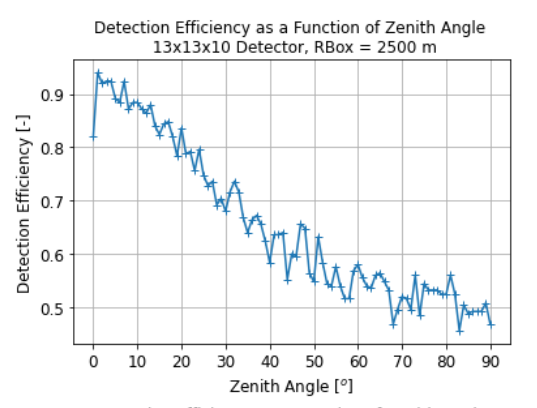

In [ ]:
# Lets try to approximate it with a line
x = np.linspace(0, 91, 92)

y = [0.82, 0.95, 0.92, 0.922, 0.922, 0.89, 0.885, 0.922, 0.875, 0.89,
     0.89, 0.875, 0.87, 0.885, 0.84, 0.82, 0.845, 0.85, 0.82, 0.78, 
     0.835, 0.785, 0.79, 0.755, 0.795, 0.745, 0.73, 0.735, 0.69, 0.7, 
     0.68, 0.715, 0.735, 0.715, 0.67, 0.64, 0.665, 0.67, 0.66, 0.625, 
     0.58, 0.64, 0.64, 0.645, 0.55, 0.6, 0.595, 0.66, 0.655, 0.56,
     0.55, 0.64, 0.58, 0.545, 0.54, 0.575, 0.54, 0.52, 0.52, 0.57,
     0.58, 0.56, 0.54, 0.535, 0.565, 0.57, 0.555, 0.535, 0.47, 0.495,
     0.52, 0.52, 0.495, 0.57, 0.485, 0.55, 0.54, 0.54, 0.54, 0.535,
     0.535, 0.57, 0.535, 0.46, 0.505, 0.49, 0.495, 0.495, 0.495, 0.505,
     0.47, 0]

maxi = np.max(y)



y = [(1/maxi) * i for i in y]

plt.plot(x, y)

plt.xlim(-3, 90)
plt.ylim(0.43, 0.98)

Now we have a sensitivity for each angle and this can be used in a sky map

In [ ]:
def points_in_90_degree_angle_sensitivity(ref_lon, ref_lat, lon_points, lat_points, y):
    # Convert reference point coordinates to Cartesian coordinates
    ref_x = np.cos(ref_lat) * np.cos(ref_lon)
    ref_y = np.cos(ref_lat) * np.sin(ref_lon)
    distance_Tanganyika = (((ref_lat + np.pi) - (lat_points * np.pi + np.pi))**2 + (ref_lon + np.pi - (lon_points + np.pi))**2)**(1/2)

    within_90 = np.where(distance_Tanganyika < np.radians(90), distance_Tanganyika, np.radians(91))
    within_90_degrees = (np.degrees(within_90))
    within_90_degrees = [round(i) for i in within_90_degrees]

    sensitivity = [y[i] for i in within_90_degrees]

    return sensitivity

def update_positions_exposure_sensitivity(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    daily_rotation = np.radians(frame / 1500 * 360)  # Assuming 24 hours in a day
    ra_points_updated = (ra + daily_rotation) % (2 * np.pi)
    ra_points_updated = np.where(ra_points_updated > int(np.pi), (ra_points_updated - (2 * np.pi)), ra_points_updated)
    return ra_points_updated, dec

In [ ]:
# Set the start date for your simulation
start_date = datetime.datetime(2024, 1, 1) 
    
# For every second in one day we make a frame
frames = 1500

# Define the Mollweide projection into pixels
nside = 32 
npix = hp.nside2npix(nside)

# List to store pixel coordinates
pixel_longitudes = []
pixel_latitudes = []

# Calculate coordinates for each pixel in degrees
for ipix in range(npix):
    lon_pixel, lat_pixel = hp.pix2ang(nside, ipix, lonlat=True)
    pixel_longitudes.append(lon_pixel)
    pixel_latitudes.append(1/3 * lat_pixel)

# Convert the lists to a NumPy array
pixel_longitudes = np.array(np.radians(pixel_longitudes) - np.pi) 
pixel_latitudes = np.array(np.radians(pixel_latitudes))


# Define a circle around Tanganyika with a x degree view circle and save these in variables
Tanganyika_lat_rad = np.radians(Tanganyika_lat)
Tanganyika_lon_rad = np.radians(Tanganyika_lon)
Pylos_lat_rad = np.radians(Pylos_lat)
Pylos_lon_rad = np.radians(Pylos_lon)	

radius_degrees = 90.0

# Initialize an array to accumulate counts for each time a pixel is in the circle of the detector
Wcounts90 = np.zeros(len(pixel_longitudes), dtype=int)
Wcounts91 = np.zeros(len(pixel_longitudes), dtype=int)

# Loop throught the hours and check if the pixel falls inside the defined circle
for frame in range(0, frames):
    pixel_longitudes_new, pixel_latitudes_new = update_positions_exposure_sensitivity(frame, pixel_longitudes, pixel_latitudes)
    points_within_90_degrees = points_in_90_degree_angle_sensitivity(Tanganyika_lon_rad, Tanganyika_lat_rad, pixel_longitudes_new, pixel_latitudes_new, y)
    points_within_90_degrees1 = points_in_90_degree_angle_sensitivity(Pylos_lon_rad, Pylos_lat_rad, pixel_longitudes_new, pixel_latitudes_new, y)
    
    # Increment counts based on true values in points_within_90_degrees
    Wcounts90 = Wcounts90 + points_within_90_degrees
    Wcounts91 = Wcounts91 + points_within_90_degrees1 
    # visualise the code but only for small values
    #plt.scatter(Tanganyika_lat / np.pi, Tanganyika_lon / np.pi, color='yellow')
    #plt.scatter(pixel_longitudes_new[points_within_90_degrees], pixel_latitudes_new[points_within_90_degrees], color='green', label='Within 90 Degrees')
    #plt.scatter(pixel_longitudes_new[~points_within_90_degrees], pixel_latitudes_new[~points_within_90_degrees], color='red', label='Outside 90 Degrees')
    #plt.xlim(-3, 3)
    #plt.ylim(-0.5, 0.5)
    #plt.show()

print(counts90)
print(counts91)

In [ ]:
# Plot the heatmap in Aitoff projection 90 degrees
counts_smoothed90 = hp.smoothing(counts90, fwhm=np.radians(1.))
hp.mollview(counts_smoothed90, title='Exposure Map Tanganyika 90 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='YlGnBu_r', min=0, max=750, rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
#plt.savefig("Exposure Tanganyika.jpg")
plt.show()

# Plot the heatmap in Aitoff projection 90 degrees
Wcounts_smoothed90 = hp.smoothing(Wcounts90, fwhm=np.radians(1.))
hp.mollview(Wcounts_smoothed90, title='Exposure Map Tanganyika RBox=2500m', coord=["C", "G"], unit="Weighted Exposure [-]", cmap='YlGnBu_r', min=0, max=519, rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.savefig("Exposure Tanganyika Kevin.jpg")
plt.show()

counts_smoothed91 = hp.smoothing(counts91, fwhm=np.radians(1.))
hp.mollview(counts_smoothed91, title='Exposure Map Pylos 90 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='YlGnBu_r', min=0, max=750, rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
#plt.savefig("Exposure Pylose.jpg")
plt.show()

Wcounts_smoothed91 = hp.smoothing(Wcounts91, fwhm=np.radians(1.))
hp.mollview(Wcounts_smoothed91, title='Exposure Map Pylos RBox=2500m', coord=["C", "G"], unit="Weighted Exposure [-]", cmap='YlGnBu_r', min=0, max=519, rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.savefig("Exposure Pylos Kevin.jpg")
plt.show()


# Again but now with my own sensitivities

In [ ]:
# Lets try to approximate it with a line
x = np.linspace(0, 91, 92)

yP = [0.12116402, 0.1223176, 0.11843277, 0.1214104, 0.11770024, 0.11959654,
 0.11384784, 0.11277247, 0.11341507, 0.11032991, 0.10977337, 0.10839914,
 0.10876565, 0.10782733, 0.10369445, 0.09285589, 0.10680137, 0.09622175,
 0.09636594, 0.09377276, 0.08466454, 0.08968283, 0.09226084, 0.083213,
 0.08474576, 0.08320085, 0.08395151, 0.07847372, 0.07744169, 0.07606383,
 0.07743205, 0.06284691, 0.07285483, 0.07238367, 0.0651368, 0.06193078,
 0.06671462, 0.06663055, 0.06435194, 0.0648213, 0.06355311, 0.0602881,
 0.06244519, 0.06521739, 0.05737557, 0.0596289, 0.05863074, 0.06345811,
 0.05908845, 0.06100698, 0.05816398, 0.05772711, 0.05570292, 0.05869873,
 0.05768884, 0.05590851, 0.05492933, 0.05380601, 0.05185053, 0.05261274,
 0.04962461, 0.05514184, 0.05290909, 0.05077063, 0.04768734, 0.05066279,
 0.05147059, 0.05031789, 0.05168377, 0.05505415, 0.04537303, 0.04779344,
 0.04962598, 0.0483552, 0.04591385, 0.04679218, 0.05134695, 0.04752439,
 0.046337, 0.04701398, 0.05113636, 0.04337737, 0.04656994, 0.04977293,
 0.04401503, 0.04540521, 0.0477574, 0.04267161, 0.04266427, 0.04803092, 0.04803092, 0.0]


yT = [0.29103089, 0.28169522, 0.27317699, 0.26429224, 0.24768023, 0.21426006,
 0.19590223, 0.19276893, 0.15278515, 0.14725473, 0.14537921, 0.1363472,
 0.12004249, 0.11984747, 0.11062591, 0.11215297, 0.09907625, 0.0990099,
 0.09735794, 0.09892665, 0.08369099, 0.0812662, 0.08074195, 0.07543025,
 0.07675944, 0.07459165, 0.07738529, 0.06395773, 0.07501321, 0.07140332,
 0.06841155, 0.06317886, 0.06301321, 0.06276075, 0.06478975, 0.06189451,
 0.05826631, 0.06439942, 0.05774044, 0.05936155, 0.04967486, 0.05756851,
 0.05965293, 0.05475975, 0.05345801, 0.05473266, 0.05301809, 0.05739796,
 0.05157326, 0.04637422, 0.04674247, 0.04992842, 0.0469905, 0.04634453,
 0.04969271, 0.04584104, 0.04920405, 0.04694752, 0.04803571, 0.05110399,
 0.04542203, 0.04911956, 0.04595685, 0.04794763, 0.04883463, 0.04515659,
 0.04600397, 0.04246696, 0.04726947, 0.04344767, 0.04453367, 0.04732548,
 0.04153124, 0.04594153, 0.04188003, 0.04555315, 0.04670723, 0.04304694,
 0.04571027, 0.0430605, 0.04159099, 0.03757022, 0.04318344, 0.04167402,
 0.04021873, 0.04017531, 0.03866305, 0.04080146, 0.04198406, 0.04057451, 0.04057451, 0.0]

maxP = np.max(yP)
maxT = np.max(yT)

print(maxT)
print(maxP)
print(x)


yT = [(1/maxT) * i for i in yT]
yP = [(1/maxT) * i for i in yP]

plt.plot(x, yP)
plt.plot(x, yT)
plt.xlim(-3, 93)


In [ ]:
def points_in_90_degree_angle_sensitivity(ref_lon, ref_lat, lon_points, lat_points, y):
    # Convert reference point coordinates to Cartesian coordinates
    ref_x = np.cos(ref_lat) * np.cos(ref_lon)
    ref_y = np.cos(ref_lat) * np.sin(ref_lon)
    distance_Tanganyika = (((ref_lat + np.pi) - (lat_points * np.pi + np.pi))**2 + (ref_lon + np.pi - (lon_points + np.pi))**2)**(1/2)

    within_90 = np.where(distance_Tanganyika < np.radians(90), distance_Tanganyika, np.radians(91))
    within_90_degrees = (np.degrees(within_90))
    within_90_degrees = [round(i) for i in within_90_degrees]

    sensitivity = [y[i] for i in within_90_degrees]

    return sensitivity

def update_positions_exposure_sensitivity(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    daily_rotation = np.radians(frame / 1500 * 360)  # Assuming 24 hours in a day
    ra_points_updated = (ra + daily_rotation) % (2 * np.pi)
    ra_points_updated = np.where(ra_points_updated > int(np.pi), (ra_points_updated - (2 * np.pi)), ra_points_updated)
    return ra_points_updated, dec

In [ ]:
# Set the start date for your simulation
start_date = datetime.datetime(2024, 1, 1) 
    
# For every second in one day we make a frame
frames = 1500

# Define the Mollweide projection into pixels
nside = 32 
npix = hp.nside2npix(nside)

# List to store pixel coordinates
pixel_longitudes = []
pixel_latitudes = []

# Calculate coordinates for each pixel in degrees
for ipix in range(npix):
    lon_pixel, lat_pixel = hp.pix2ang(nside, ipix, lonlat=True)
    pixel_longitudes.append(lon_pixel)
    pixel_latitudes.append(1/3 * lat_pixel)

# Convert the lists to a NumPy array
pixel_longitudes = np.array(np.radians(pixel_longitudes) - np.pi) 
pixel_latitudes = np.array(np.radians(pixel_latitudes))


# Define a circle around Tanganyika with a x degree view circle and save these in variables
Tanganyika_lat_rad = np.radians(Tanganyika_lat)
Tanganyika_lon_rad = np.radians(Tanganyika_lon)
Pylos_lat_rad = np.radians(Pylos_lat)
Pylos_lon_rad = np.radians(Pylos_lon)	

radius_degrees = 90.0

# Initialize an array to accumulate counts for each time a pixel is in the circle of the detector
Wcounts90 = np.zeros(len(pixel_longitudes), dtype=int)
Wcounts91 = np.zeros(len(pixel_longitudes), dtype=int)

# Loop throught the hours and check if the pixel falls inside the defined circle
for frame in range(0, frames):
    pixel_longitudes_new, pixel_latitudes_new = update_positions_exposure_sensitivity(frame, pixel_longitudes, pixel_latitudes)
    points_within_90_degrees = points_in_90_degree_angle_sensitivity(Tanganyika_lon_rad, Tanganyika_lat_rad, pixel_longitudes_new, pixel_latitudes_new, yT)
    points_within_90_degrees1 = points_in_90_degree_angle_sensitivity(Pylos_lon_rad, Pylos_lat_rad, pixel_longitudes_new, pixel_latitudes_new, yP)
    
    # Increment counts based on true values in points_within_90_degrees
    Wcounts90 = Wcounts90 + points_within_90_degrees
    Wcounts91 = Wcounts91 + points_within_90_degrees1 
    # visualise the code but only for small values
    #plt.scatter(Tanganyika_lat / np.pi, Tanganyika_lon / np.pi, color='yellow')
    #plt.scatter(pixel_longitudes_new[points_within_90_degrees], pixel_latitudes_new[points_within_90_degrees], color='green', label='Within 90 Degrees')
    #plt.scatter(pixel_longitudes_new[~points_within_90_degrees], pixel_latitudes_new[~points_within_90_degrees], color='red', label='Outside 90 Degrees')
    #plt.xlim(-3, 3)
    #plt.ylim(-0.5, 0.5)
    #plt.show()

print(counts90)
print(counts91)

In [ ]:
# Plot the heatmap in Aitoff projection 90 degrees
counts_smoothed90 = hp.smoothing(counts90, fwhm=np.radians(1.))
hp.mollview(counts_smoothed90, title='Exposure Map Tanganyika 90 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='YlGnBu_r', min=0, max=750, rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
#plt.savefig("Exposure Tanganyika.jpg")
plt.show()

# Plot the heatmap in Aitoff projection 90 degrees
Wcounts_smoothed90 = hp.smoothing(Wcounts90, fwhm=np.radians(1.))
hp.mollview(Wcounts_smoothed90, title='Exposure Map Tanganyika RBox=17500m', coord=["C", "G"], unit="Weighted Exposure [-]", cmap='YlGnBu_r', min=0, max=200, rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.savefig("Exposure Tanganyika Lene.jpg")
plt.show()

counts_smoothed91 = hp.smoothing(counts91, fwhm=np.radians(1.))
hp.mollview(counts_smoothed91, title='Exposure Map Pylos 90 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='YlGnBu_r', min=0, max=750, rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
#plt.savefig("Exposure Pylos.jpg")
plt.show()

Wcounts_smoothed91 = hp.smoothing(Wcounts91, fwhm=np.radians(1.))
hp.mollview(Wcounts_smoothed91, title='Exposure Map Pylos RBox=15000', coord=["C", "G"], unit="Weighted Exposure [-]", cmap='YlGnBu_r', min=0, max=200, rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.savefig("Exposure Pylos Lene.jpg")
plt.show()


# Now do it again with the values out of the Bellhop simulation

In [ ]:
# Only the clean arrivals
yTB = [0, 0, 0, 0, 4, 2, 3, 2, 2, 1, 0, 1, 1, 
       1, 0, 1, 2, 1, 1, 2, 2, 1, 1,
       1, 4, 4, 2, 0, 2, 1, 2, 0, 3, 
       0, 3, 1, 3, 1, 1, 4, 3, 2, 4,
       2, 3, 2, 6, 0, 3, 1, 5, 8, 2,
       2, 3, 6, 2, 3, 3, 6, 6, 10, 5,
       7, 13, 6, 13, 9, 15, 14, 12, 13,
       9, 12, 18, 25, 25, 16, 29, 34, 34,
       55, 58, 301, 530, 2836, 2367, 2582,
       2179, 1890, 1960, 1615]

yTB = yTB[::-1]

yPB = [0, 0, 0, 14, 7, 11, 7, 8, 1, 5, 2, 5, 6, 3, 2, 6, 4, 7, 7, 8,
       2, 2, 3, 3, 4, 3, 5, 3, 5, 4, 4, 9, 7, 8, 9, 6, 2, 8,
       7, 8, 11, 7, 14, 10, 7, 10, 7, 9, 17, 11, 13, 6, 18, 16, 11, 12,
      14, 16, 10, 21, 20, 24, 23, 26, 23, 20, 30, 25, 31, 33, 38, 43, 63, 65,
      91, 102, 295, 585, 692, 689, 671, 576, 490, 443, 399, 357, 313, 292, 265, 304, 900, 986,]

yPB = yPB[::-1]

maxPB = np.max(yPB)
maxTB = np.max(yTB)

print(maxPB)
print(maxTB)


yTB = [(1/maxTB) * i for i in yTB]
yPB = [(1/maxTB) * i for i in yPB]

plt.plot(x, yPB)
plt.plot(x, yTB)
plt.xlim(-3, 93)

In [ ]:
# The no surface bounce and no bottom bounce arrivals
yTB = [0, 0, 12, 15, 11, 11, 11, 16, 7, 10, 10, 10, 18, 13, 13, 14, 13, 10, 20, 14, 15, 8, 16, 23, 12, 16, 12, 15, 12, 15, 17,
    16, 22, 17, 10, 25, 17, 16, 23, 28, 10, 26, 23, 28, 31, 17, 33, 24, 24, 51, 26, 25, 39, 26, 34, 32, 34, 49, 49, 53,
    40, 40, 75, 58, 82, 83, 82, 91, 84, 107, 97, 126, 137, 139, 175, 174, 232, 263, 308, 420, 632, 1992, 2999, 3856, 3854,
    5021, 9132, 7598, 6388, 4763, 4230, 4288]

yTB = yTB[::-1]

yPB = [0, 0, 46, 83, 41, 45, 54, 36, 46, 51, 30, 36, 41, 32, 37, 37, 45, 55, 50, 41, 47, 34, 37, 28, 41, 48, 39, 36, 40,
    45, 53, 55, 64, 54, 64, 53, 58, 54, 60, 67, 58, 81, 68, 77, 60, 71, 66, 98, 93, 96, 71, 100, 98, 90, 113, 105, 102,
    106, 138, 157, 156, 148, 167, 178, 183, 220, 232, 246, 253, 301, 336, 409, 505, 595, 863, 1781, 2507, 2969, 3146,
    3114, 2999, 2799, 2664, 2330, 2382, 2247, 2307, 2277, 2131, 2875, 3271, 3484]

yPB = yPB[::-1]

maxPB = np.max(yPB)
maxTB = np.max(yTB)

yTB = [(1/maxTB) * i for i in yTB]
yPB = [(1/maxPB) * i for i in yPB]

plt.plot(x, yPB)
plt.plot(x, yTB)
plt.xlim(-3, 93)

In [ ]:
def points_in_90_degree_angle_sensitivity(ref_lon, ref_lat, lon_points, lat_points, y):
    # Convert reference point coordinates to Cartesian coordinates
    ref_x = np.cos(ref_lat) * np.cos(ref_lon)
    ref_y = np.cos(ref_lat) * np.sin(ref_lon)
    distance_Tanganyika = (((ref_lat + np.pi) - (lat_points * np.pi + np.pi))**2 + (ref_lon + np.pi - (lon_points + np.pi))**2)**(1/2)

    within_90 = np.where(distance_Tanganyika < np.radians(90), distance_Tanganyika, np.radians(91))
    within_90_degrees = (np.degrees(within_90))
    within_90_degrees = [round(i) for i in within_90_degrees]

    sensitivity = [y[i] for i in within_90_degrees]

    return sensitivity

def update_positions_exposure_sensitivity(frame, ra, dec):
    # Update positions based on Earth's rotation (daily cycle)
    daily_rotation = np.radians(frame / 1500 * 360)  # Assuming 24 hours in a day
    ra_points_updated = (ra + daily_rotation) % (2 * np.pi)
    ra_points_updated = np.where(ra_points_updated > int(np.pi), (ra_points_updated - (2 * np.pi)), ra_points_updated)
    return ra_points_updated, dec

In [ ]:
# Set the start date for your simulation
start_date = datetime.datetime(2024, 1, 1) 
    
# For every second in one day we make a frame
frames = 1500

# Define the Mollweide projection into pixels
nside = 32 
npix = hp.nside2npix(nside)

# List to store pixel coordinates
pixel_longitudes = []
pixel_latitudes = []

# Calculate coordinates for each pixel in degrees
for ipix in range(npix):
    lon_pixel, lat_pixel = hp.pix2ang(nside, ipix, lonlat=True)
    pixel_longitudes.append(lon_pixel)
    pixel_latitudes.append(1/3 * lat_pixel)

# Convert the lists to a NumPy array
pixel_longitudes = np.array(np.radians(pixel_longitudes) - np.pi) 
pixel_latitudes = np.array(np.radians(pixel_latitudes))


# Define a circle around Tanganyika with a x degree view circle and save these in variables
Tanganyika_lat_rad = np.radians(Tanganyika_lat)
Tanganyika_lon_rad = np.radians(Tanganyika_lon)
Pylos_lat_rad = np.radians(Pylos_lat)
Pylos_lon_rad = np.radians(Pylos_lon)	

radius_degrees = 90.0

# Initialize an array to accumulate counts for each time a pixel is in the circle of the detector
Wcounts90 = np.zeros(len(pixel_longitudes), dtype=int)
Wcounts91 = np.zeros(len(pixel_longitudes), dtype=int)

# Loop throught the hours and check if the pixel falls inside the defined circle
for frame in range(0, frames):
    pixel_longitudes_new, pixel_latitudes_new = update_positions_exposure_sensitivity(frame, pixel_longitudes, pixel_latitudes)
    points_within_90_degrees = points_in_90_degree_angle_sensitivity(Tanganyika_lon_rad, Tanganyika_lat_rad, pixel_longitudes_new, pixel_latitudes_new, yTB)
    points_within_90_degrees1 = points_in_90_degree_angle_sensitivity(Pylos_lon_rad, Pylos_lat_rad, pixel_longitudes_new, pixel_latitudes_new, yPB)
    
    # Increment counts based on true values in points_within_90_degrees
    Wcounts90 = Wcounts90 + points_within_90_degrees
    Wcounts91 = Wcounts91 + points_within_90_degrees1 
    # visualise the code but only for small values
    #plt.scatter(Tanganyika_lat / np.pi, Tanganyika_lon / np.pi, color='yellow')
    #plt.scatter(pixel_longitudes_new[points_within_90_degrees], pixel_latitudes_new[points_within_90_degrees], color='green', label='Within 90 Degrees')
    #plt.scatter(pixel_longitudes_new[~points_within_90_degrees], pixel_latitudes_new[~points_within_90_degrees], color='red', label='Outside 90 Degrees')
    #plt.xlim(-3, 3)
    #plt.ylim(-0.5, 0.5)
    #plt.show()

print(counts90)
print(counts91)

In [ ]:
# Plot the heatmap in Aitoff projection 90 degrees
counts_smoothed90 = hp.smoothing(counts90, fwhm=np.radians(1.))
hp.mollview(counts_smoothed90, title='Exposure Map Tanganyika 90 degrees', coord=["C", "G"], unit="Exposure [-]", cmap='YlGnBu_r', min=0, rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
#plt.savefig("Exposure Tanganyika.jpg")
plt.show()

# Plot the heatmap in Aitoff projection 90 degrees
Wcounts_smoothed90 = hp.smoothing(Wcounts90, fwhm=np.radians(1.))
hp.mollview(Wcounts_smoothed90, title='Exposure Map Tanganyika Ray Trace Bounce', coord=["C", "G"], unit="Exposure [-]", cmap='YlGnBu_r', min=0, max=750, rot=(0, 0, 0))
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.savefig("Weighted Exposure Tanganyika Bellhop.jpg")
plt.show()

counts_smoothed91 = hp.smoothing(counts91, fwhm=np.radians(1.))
hp.mollview(counts_smoothed91, title='Exposure Map Pylos 90 degrees', coord=["C", "G"], unit="Weighted Exposure [-]", cmap='YlGnBu_r', min=0, max=750, rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
#plt.savefig("Exposure Pylos.jpg")
plt.show()

Wcounts_smoothed91 = hp.smoothing(Wcounts91, fwhm=np.radians(1.))
hp.mollview(Wcounts_smoothed91, title='Exposure Map Pylos Ray Trace Bounce', coord=["C", "G"], unit="Exposure [-]", cmap='YlGnBu_r', min=0, max=750, rot=(0, 0, 0))    
# Add custom grid lines for longitude and latitude
hp.graticule(dpar=30, dmer=45)
plt.savefig("Weighted Exposure Pylos Bellhop.jpg")
plt.show()


# Make maps showing the most important points in the sky for research

In [ ]:
# GALACTIC
# Combine AGN and blazar data into a single DataFrame 
agn_data_galactic = pd.DataFrame({'RA': l_points, 'Dec': b_points, 'Type': 'AGN'})
blazar_data_galactic = pd.DataFrame({'RA': ra, 'Dec': dec, 'Type': 'Blazar'})
combined_data_galactic = pd.concat([agn_data_galactic, blazar_data_galactic], ignore_index=True)
print(len(agn_data_galactic))
print(len(blazar_data_galactic))

# Convert RA and Dec columns to numeric
combined_data_galactic['RA'] = pd.to_numeric(combined_data_galactic['RA'], errors='coerce')
combined_data_galactic['Dec'] = pd.to_numeric(combined_data_galactic['Dec'], errors='coerce')
print(len(combined_data_galactic['RA']))

# Add columns for AGN and Blazar weights
weights_galactic = pd.concat([pd.Series(s), pd.Series(b)], ignore_index=True)

# CELESTIAL
# Combine AGN and blazar data into a single DataFrame
agn_data = pd.DataFrame({'RA': df['RAdeg'], 'Dec': df['DEdeg'], 'Type': 'AGN'})
blazar_data = pd.DataFrame({'RA': ra_blazar, 'Dec': dec_blazar, 'Type': 'Blazar'})
combined_data = pd.concat([agn_data, blazar_data], ignore_index=True)
print(len(agn_data))
print(len(blazar_data))

# Convert RA and Dec columns to numeric
combined_data['RA'] = pd.to_numeric(combined_data['RA'], errors='coerce')
combined_data['Dec'] = pd.to_numeric(combined_data['Dec'], errors='coerce')
print(len(combined_data['RA']))

# Add columns for AGN and Blazar weights
weights = pd.concat([pd.Series(s), pd.Series(b)], ignore_index=True)

In [ ]:
# Assuming combined_data['RA'] and combined_data['Dec'] are your right ascension and declination arrays
ra_set = combined_data_galactic['RA']
dec_set = combined_data_galactic['Dec']

# Specify the number of bins in each direction
ra_bins = np.linspace(-np.pi, np.pi, num=50)
dec_bins = np.linspace(-np.pi/2, np.pi/2, num=50)

# Use numpy.histogram2d to create a 2D histogram with weights
hist, ra_edges, dec_edges = np.histogram2d(ra_set, dec_set, bins=[ra_bins, dec_bins], weights=weights_galactic)

# Create a meshgrid from the edges
RA, DEC = np.meshgrid(ra_edges, dec_edges)

# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Overlay the KDE plot
kde = sns.kdeplot(x=ra_set, y=dec_set, cmap='viridis', fill=True, thresh=0, levels=100, weights=weights_galactic, ax=ax, zorder=0, bw_method=1)

plt.scatter(l_eq_gal, b_eq_gal, s=6, marker='v', label='Celestial Equator', color='black')
plt.scatter(l_ecl_gal, b_ecl_gal, s=6, marker='^', label='Ecliptic', color='red')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]))
ax.set_xticklabels(['', '150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°', ''], color='yellow')

ax.set_xlabel('l = Longitude (degrees)')
ax.set_ylabel('b = Latitude (degrees)')

# Set the zorder for the x-axis and y-axis
ax.xaxis.set_zorder(2)
ax.yaxis.set_zorder(2)

plt.grid(True, alpha=0.3, color='gray')
plt.title('Galactic', fontsize='16')
plt.legend(fontsize=16, loc='lower right')

plt.show()



# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Plot the 2D histogram using pcolormesh first
pc = ax.pcolormesh(RA, DEC, hist.T, cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=hist.max()), zorder=1)
ax.set_facecolor('black')

plt.scatter(l_eq_gal, b_eq_gal, s=6, marker='v', label='Celestial Equator', color='black')
plt.scatter(l_ecl_gal, b_ecl_gal, s=6, marker='^', label='Ecliptic', color='red')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]))
ax.set_xticklabels(['', '150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°', ''], color='yellow')

ax.set_xlabel('l = Longitude (degrees)')
ax.set_ylabel('b = Latitude (degrees)')

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax, orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_label('Flux Density')

# Set the zorder for the x-axis and y-axis
ax.xaxis.set_zorder(2)
ax.yaxis.set_zorder(2)

plt.grid(True, alpha=0.3, color='gray')
plt.title('Galactic', fontsize='16')

plt.show()

In [ ]:
# Assuming combined_data['RA'] and combined_data['Dec'] are your right ascension and declination arrays
ra_set = -np.radians(combined_data['RA'] - 180)
dec_set = np.radians(combined_data['Dec'])

# Specify the number of bins in each direction
ra_bins = np.linspace(-np.pi, np.pi, num=50)
dec_bins = np.linspace(-1/2*np.pi, 1/2*np.pi, num=50)

# Use numpy.histogram2d to create a 2D histogram with weights
hist, ra_edges, dec_edges = np.histogram2d(ra_set, dec_set, bins=[ra_bins, dec_bins], weights=weights)

# Create a meshgrid from the edges
RA, DEC = np.meshgrid(ra_edges, dec_edges)

# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Overlay the KDE plot
sns.kdeplot(x=ra_set, y=dec_set, cmap='viridis', fill=True, thresh=0, levels=100, weights=weights, ax=ax, bw_method=1)
ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='red')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='red')
ax.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]))
ax.set_xticklabels(['', '150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°', ''], color='yellow')

ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')

# Set the zorder for the x-axis and y-axis
ax.xaxis.set_zorder(2)
ax.yaxis.set_zorder(2)

plt.grid(True, alpha=0.3, color='gray')
plt.title('Celestial', fontsize='16')
plt.legend(fontsize=16, loc='lower right')

plt.show()



# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Plot the 2D histogram using pcolormesh first
pc = ax.pcolormesh(RA, DEC, hist.T, cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=hist.max()), zorder=1)
ax.set_facecolor('black')

ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='red')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='red')
ax.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]))
ax.set_xticklabels(['', '150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°', ''], color='yellow')

ax.set_xlabel('l = Longitude (degrees)')
ax.set_ylabel('b = Latitude (degrees)')

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax, orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_label('Flux Density')

# Set the zorder for the x-axis and y-axis
ax.xaxis.set_zorder(2)
ax.yaxis.set_zorder(2)

plt.grid(True, alpha=0.5, color='gray')
plt.title('Celestial', fontsize='16')

plt.show()

In [ ]:
# Assuming combined_data['RA'] and combined_data['Dec'] are your right ascension and declination arrays
ra_set = -np.radians(combined_data['RA'] - 180)
dec_set = np.radians(combined_data['Dec'])

# Specify the number of bins in each direction such that we have two hemispheres
ra_bins = np.linspace(-np.pi, np.pi, num=2)
dec_bins = np.linspace(-1/2*np.pi, 1/2*np.pi, num=3)

# Use numpy.histogram2d to create a 2D histogram with weights and calculate the histogram value for each of the hemispheres
hist, ra_edges, dec_edges = np.histogram2d(ra_set, dec_set, bins=[ra_bins, dec_bins], weights=weights)

print(f"The histogram value for the northern hemisphere, which represents the flux is {round(hist[0][1])}. That of the sourthern hemisphere is {round(hist[0][0])}. This means that the flux in the northern hemisphere would be more substantial by a factor of approximately {round((hist[0][1])/(hist[0][0]), 2)}.")


Import the auger data from the following website: https://opendata.auger.org/analysis.php#nb_json

In [ ]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerLoad(fdir,file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".","..","augeropendata"]:
        fname=os.path.join(loc,fdir,file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc,fdir+".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir,file))

Look for high energy events of E > 2.5 EeV.

In [ ]:
# Safeguard: select only events above Eth = 2.5 EeV, where full efficiency is reached for zenith angles < 60°
Eth = 10 # EeV = 10^19 eV
e_cut = (raw_data.sd_energy>Eth)
data = raw_data[e_cut]
totalExposure = data.sd_exposure.iloc[-1]

# Example: print the energy and the galactic coordinates of a randomly selected event
event = np.random.randint(0, data.shape[0])
example = data.iloc[event]

display(Latex(f'''Event #{event}:
\\begin{{align}}
E &= {example.sd_energy}\\,\\mathrm{{EeV}}\\\\
l &= {example.sd_l} ^\circ\\\\
b &= {example.sd_b} ^\circ\\\\
\\end{{align}}
'''))



# In order to plot the dots with size representing energy we do the following
energy = data.sd_energy
print()
size_scaling_factor = 100.0
sizes = size_scaling_factor * energy / max(energy)

In [ ]:
print(data.sd_energy)

# Take out the coordinates from the data frame
ra_points = -(df['RAdeg'] - 180)
dec_points = np.radians(df['DEdeg'])  # Assuming you want to negate declinations

# Transform RA to the range [0, 360)
ra_points = np.radians(ra_points)

# Equatorial plane
ra_all = np.linspace(-180, 180, 100)
dec_0 = np.zeros(100)
l_eq_cel, b_eq_cel = np.radians(ra_all), np.radians(dec_0)

# Ecliptic plane
lon_ecl = np.linspace(-180, 180, 100)
lat_ecl = np.zeros(100)
l_ecl_cel, b_ecl_cel = ecl2eq(lon_ecl, lat_ecl)

# Galactic plane
l_gal_plane = np.linspace(-180, 180, 100)
b_gal_plane = np.zeros(100)
l_gal_cel, b_gal_cel = gal2eq(l_gal_plane, b_gal_plane)

# Determine the hemisphere (North or South) based on celestial latitude
is_northern_hemisphere = ra_all >= 0



# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Fill the area above the celestial equator with a different color
ax.fill_between(np.radians(l_gal_cel), np.pi, where=is_northern_hemisphere, alpha=0.01)

# Fill the area below the celestial equator with a different color
ax.fill_between(np.radians(l_eq_gal), -np.pi, where=~is_northern_hemisphere, color='yellow', alpha=0.1)

# plot the figure
ax.scatter(data.sd_ra, np.radians(data.sd_dec), s=sizes, color='darkviolet', label='Auger Sources')
ax.scatter(ra_points, dec_points, s=s, label='AGN', color='blue', alpha=0.1)
ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='red')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='red')
ax.scatter(l_gal_cel, b_gal_cel, s=4, label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])


ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.title('Celestial', fontsize='16')

plt.show()